## Feature Extraction: Neurophysiology [dyskinesia project]

This notebooks helps to extract features from preprocessed ECoG and LFP (STN electrodes) data within the ReTune-Dyskinesia project.

Data is required to be preprocessed, for example with the corresponding preprocess functions.

<b> Content </b>


<b> Periodic component analysis: </b> 
- Try Wavelet Dceomposition vs Welch (tapered) Spectral Decomposition



<b> Aperiodic estimates </b>
Relevant literature:
- Periodic and a-periodic components relevance and interaction, different reasons (per + a-per) for signal changes observed within a specific bandwidth. Aperiodic component (complicated) vs exponent (1/f) (Donoghue, ..., Shestyuk & Voytek, Nature Neurosc 2020 : https://www.nature.com/articles/s41593-020-00744-x)
- cycle-by-cycle features: bycycle toolbox (Cole & Voytek, J of Neurophys 2019, https://journals.physiology.org/doi/full/10.1152/jn.00273.2019)

### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
from abc import ABCMeta, abstractmethod
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import ghostipy as gsp
from pacpy.pac import plv
from scipy import fftpack, stats
from array import array
import datetime
# #mne
# import mne_bids
# import mne


In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
pandas 1.3.4
numpy 1.20.3
sci-py 1.7.1
sci-kit learn 1.0.1


In [3]:
# define local storage directories
projectpath = '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'
codepath = os.path.join(projectpath, 'code')
pynmd_path = os.path.join(codepath, 'py_neuromodulation')
rawdatapath = '/Users/jeroenhabets/OneDrive - Charité - Universitätsmedizin Berlin/BIDS_Berlin_ECOG_LFP/rawdata'
proc_data_path = os.path.join(projectpath, 'data/preprocess')
# change working directory to project-code folder
os.chdir(projectpath)
temp_save = os.path.join(projectpath, 'figures/TEMP')
os.getcwd()

'/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'

In [4]:
os.chdir(codepath)
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng

import lfpecog_preproc.preproc_filters as fltrs
# own data exploration functions
import lfpecog_features.feats_read_data as read_data
import lfpecog_exploration.expl_plotting as expl_plot
import lfpecog_features.handTap_detect as handTap_detect
import lfpecog_features.feats_spectral_baseline as specBase

os.chdir(projectpath)




## ACC CHECK BARBARA

In [286]:
dlFolder = '/Users/jeroenhabets/Downloads'
matfiles = [f for f in os.listdir(dlFolder) if f[-3:] == 'mat']
print(matfiles)

acc = scipy.io.loadmat(os.path.join(dlFolder, matfiles[0]))['jeroen']  # Fs 250 Hz
acc = acc.T
svm = np.sqrt(acc[0, :]**2 + acc[1, :]**2 + acc[2, :]**2)
acc = np.vstack((acc, svm))
print(acc.shape)
fs = 250


['jeroenmatex.mat', 'ffraradspmeeg_Sub-015_12mfu_MOnSoff_BStr_FTRU_LSTN-20220125T132039.mat']
(4, 240313)


#### Descriptives

In [287]:
names = ['X', 'Y', 'Z', 'SVM']
for i in [0, 1, 2, 3]:
    print(f'AXIS: {names[i]}')
    print(f'Coef of Variation axis {i}: {stats.variation(acc[i, :])}')
    print(f'Median axis {i}: {np.median(acc[i, :])}')
    print(f'Mean axis {i}: {np.mean(acc[i, :])}')
    print(f'Std dev axis {i}: {np.std(acc[i, :])}\n')

AXIS: X
Coef of Variation axis 0: 321381.59409897134
Median axis 0: 0.00013248369214124978
Mean axis 0: 8.256683701341091e-07
Std dev axis 0: 0.2653546169907995

AXIS: Y
Coef of Variation axis 1: -370494.9105419953
Median axis 1: 7.643438584636897e-05
Mean axis 1: -1.7842968783443504e-06
Std dev axis 1: 0.6610729123225516

AXIS: Z
Coef of Variation axis 2: -1484214.2117369594
Median axis 2: -2.061223085547681e-06
Mean axis 2: -2.2165861141118768e-07
Std dev axis 2: 0.3289888612103649

AXIS: SVM
Coef of Variation axis 3: 2.389134896541549
Median axis 3: 0.010657566797215568
Mean axis 3: 0.3029538785770867
Std dev axis 3: 0.723797683351129



#### Peak Detection Epochs 0 and 1

In [522]:
for i in range(10):
        print(np.diff([epoch1[3956 + i], epoch1[3956 + i + 1]]))

[-3.89066702]
[-2.20191675]
[1.03659394]
[0.55430773]
[0.15000268]
[-0.29024918]
[0.23309027]
[0.21614496]
[0.17710242]
[0.0300526]


In [649]:
fig, ax = plt.subplots(1, 1, figsize=(16,6))
clrs=['green', 'orange', 'cyan']
dirs=[1, -1]
epoch1 = acc[1, fs * 50:fs * 75]
svm1 = acc[3, fs * 50:fs * 75]

states = np.zeros((len(epoch1)))

ax.plot(epoch1)
ax.plot(svm1, color='r', alpha=.2)

# find artefacts
art_i=[]
artf = signal.find_peaks(
    epoch1,
    # height=np.max(epoch1) * .5,
    width=(1, 5),
    rel_height=.3,
    distance=fs * 0.2,  # 10 ms
    prominence=np.max(epoch1) * .5,
    wlen=25,
)
print('artfeacts',len(artf[0]))
# for i in artf[0]:  # incl only sharp artf (slope > .5 max)
#     if  epoch1[i] - epoch1[i + 1] > np.max(epoch1) * .3:
#         art_i.append(i)

highPos = signal.find_peaks(
    epoch1,
    height=np.max(epoch1) * .15,
    # width=5,
    # rel_height=.01,
    # distance=fs * 0.01,  # 10 ms
    prominence=np.max(epoch1) * .15,
    # wlen=25,
)
lowPos = signal.find_peaks(
    epoch1,
    height=(-np.max(epoch1) * .3, np.max(epoch1) * .2),
    # width=5,
    # rel_height=.1,
    # distance=fs * 0.01,  # 10 ms
    prominence=np.max(epoch1) * .05,
    # wlen=40,
)
peaksNeg = signal.find_peaks(
    -1 * epoch1,
    # height=np.max(epoch1) * .10,
    width=5,
    distance=fs * 0.01,  # 10 ms
    prominence=np.max(epoch1) * .1,
    # wlen=40,
)

# set states (artf, peak, trough) in one array
for i in np.arange(len(states)):
    if i in artf[0]: states[i] = 4
    elif i in highPos[0]: states[i] = 2
    elif i in lowPos[0]: states[i] = 1
    elif i in peaksNeg[0]: states[i] = -1

for p, peaks in enumerate([highPos, peaksNeg, lowPos]):
    ax.scatter(
        peaks[0],
        # peaks[1]['peak_heights'] * dirs[p],
        epoch1[peaks[0]],
        color=clrs[p],
    )
    print(len(peaks[0]))
ax.scatter(artf[0], epoch1[artf[0]], edgecolor='red', )

# ax[0].plot(states, c='k')

# smth = pd.Series(epoch1).rolling(
#     window=3).median()
# ax[1].plot(smth)

# peaksPos = signal.find_peaks(
#     smth,
#     # height=np.max(smth) * .3,
#     width=5,
#     distance=fs * 0.01,  # 10 ms
#     prominence=np.max(epoch1) * .1,
#     # wlen=40,
# )
# peaksNeg = signal.find_peaks(
#     -1 * smth,
#     # height=np.max(smth) * .3,
#     width=5,
#     distance=fs * 0.005,  # 10 ms
#     prominence=np.max(epoch1) * .1,
#     height=0,
#     # wlen=40,
# )
# for p, peaks in enumerate([peaksPos, peaksNeg]):
#     ax[1].scatter(
#         peaks[0],
#         # peaks[1]['peak_heights'] * dirs[p],  # prominences
#         smth[peaks[0]],  # 
#         color=clrs[p],
#     )

upThr = np.max(epoch1) * .1
phase='pause1'
taps_i = []
tap_ind = [np.nan] * 6
legendDown=False
legendUp=False
# [startUp, fastestUp, highestUp, startDown, fastestDown, closeDown]
for i in np.arange(2770, len(states) - 1):

    if phase == 'decDown1':
        if np.logical_or(
            states[i] == 4,
            np.logical_and(
                states[i] == 2,
                epoch1[i] > np.max(epoch1) * .3
            )
        ):
            phase='closingTap'
    
    elif phase == 'closingTap':
        if np.diff([epoch1[i], epoch1[i + 1]]) > 0:
            # if slope goes up again after big impact peak
            tap_ind[5] = i
            try:
                if not legendDown:
                    ax.fill_betweenx(
                        y=np.arange(-2, 4),
                        x1=tap_ind[3], x2=tap_ind[5],
                        alpha=.3, facecolor='w', hatch='//',
                        edgecolor='gray',
                        label='Down movement',
                    )
                    legendDown=True
                else:
                    ax.fill_betweenx(
                        y=np.arange(-2, 4),
                        x1=tap_ind[3], x2=tap_ind[5],
                        alpha=.3, facecolor='w', hatch='//',
                        edgecolor='gray',
                    )
                
            except:
                print(f'No full tap registered yet: {tap_ind}')
            taps_i.append(tap_ind)  # stire finished tap
            tap_ind = [np.nan] * 6  # set next tap_ind to nan
            phase = 'pause1'

    elif phase == 'pause1':
        if np.logical_and(
            epoch1[i] > upThr,
            np.diff([epoch1[i], epoch1[i + 1]]) > np.max(epoch1) * .03  # was 0.05 adjusted it as tryout for smaller peaks
        ):  # if not > upThr -> stays pause
            phase = 'upAcc1'  # up1 is before up-acc-peak
            tap_ind[0] = i  # START MOVE UP
            # print('start UP', i, phase)

    elif phase == 'upAcc1':  # acc-up before acc-peak
        if np.logical_or(states[i] == 2, states[i] == 4):
            # print('acc up peak found', i)
            phase = 'upAcc2'  # after peak
        # elif epoch1[i] > 0:  # obsolete?
        #     continue
            
    elif phase == 'upAcc2':  # acc-up after acc-peak

        if np.logical_or(states[i] == 2, states[i] == 4):  # new 'start' of move up
            # current one may be false, replace
            phase = 'upAcc1'  # up1 is before up-acc-peak
            tap_ind[0] = i  # START MOVE UP
            # print('start UP correct', i)
        elif epoch1[i] < np.min(epoch1) * .1:  # end upAcc if negative and dropping down
            tap_ind[1] = i  # fastest Up
            phase = 'upDec1'  # deceller UpMove, before neg-peak
            # print('end up, fastest point, new phase:', phase, i)
            continue
        
    elif phase == 'upDec1':  # add if value is neg?
        # print('dec Up active', i)
        if np.diff([epoch1[i], epoch1[i + 1]]) > 0:
            phase = 'upDec2'  # after neg peak
            continue

    elif phase == 'upDec2':  # after (low) pos peak
        if np.logical_or(
            np.logical_or(states[i] == 1, states[i] == 2),
            epoch1[i - 1] > 0
        ):  # small peak or across zero-line
            tap_ind[2] = i  # END of Up movement (highest point)
            phase='pause2'
            if not legendUp:
                ax.fill_betweenx(
                    y=np.arange(-2, 4),
                    x1=tap_ind[0], x2=tap_ind[2],
                    alpha=.2,
                )
                legendUp= True
            else:
                ax.fill_betweenx(
                    y=np.arange(-2, 4),
                    x1=tap_ind[0], x2=tap_ind[2],
                    alpha=.2,
                )
        
    elif phase == 'pause2':
        if np.diff([epoch1[i], epoch1[i + 1]]) < np.min(epoch1) * .05:
            phase='accDown1'  # start of down
            tap_ind[3] = i
            # print('down started', i)
        
    elif phase == 'accDown1':
        if states[i] == -1:  # neg peak
            phase = 'accDown2'
            # print('neg down acc peak', i)
    
    elif phase == 'accDown2':
        if epoch1[i] > 0:  # end of acc down
            tap_ind[4] = i  # fastest point Down
            phase = 'decDown1'
            # if zero-crossing is some point as impact peak
            if np.logical_or(states[i] == 4, states[i] == 2):
                phase = 'closingTap'



     
ax.axhline(0, color='gray', alpha=.5)       
x1=2700
x2=3500
ax.legend(frameon=False)
ax.set_xlim(x1, x2)
ax.set_ylabel('Acc (m/s/s)')
ax.set_xlabel('Time (samples, 250 Hz)')
for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

fname = f'Perc_fingerTap_Test_i{x1}_{x2}'
# plt.savefig(
#     os.path.join(temp_save, 'ACC', 'fingertapping', fname),
#     dpi=150, facecolor='w',
#     )
plt.close()
# plt.show()

'''
POTENTIAL PARAMETERS:
Impact moment: artefact
Fastest moment UP: crossing zero-line between first green peak after artefact and yellow through 
Fastest moment DOWN: crossing zero-line between last yellow trough and artefact

Full tap: start after artefact: green peak -> two good yellow troughs -> green peak or artefact

'''


artfeacts 27
75
90
70


'\nPOTENTIAL PARAMETERS:\nImpact moment: artefact\nFastest moment UP: crossing zero-line between first green peak after artefact and yellow through \nFastest moment DOWN: crossing zero-line between last yellow trough and artefact\n\nFull tap: start after artefact: green peak -> two good yellow troughs -> green peak or artefact\n\n'

False

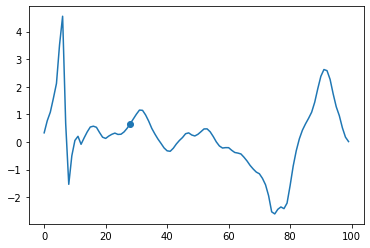

In [628]:
plt.plot(epoch1[3950:4050])
plt.scatter(28, epoch1[3978])
np.diff(epoch1[3956:3958])[0] > np.max(epoch1) * .05

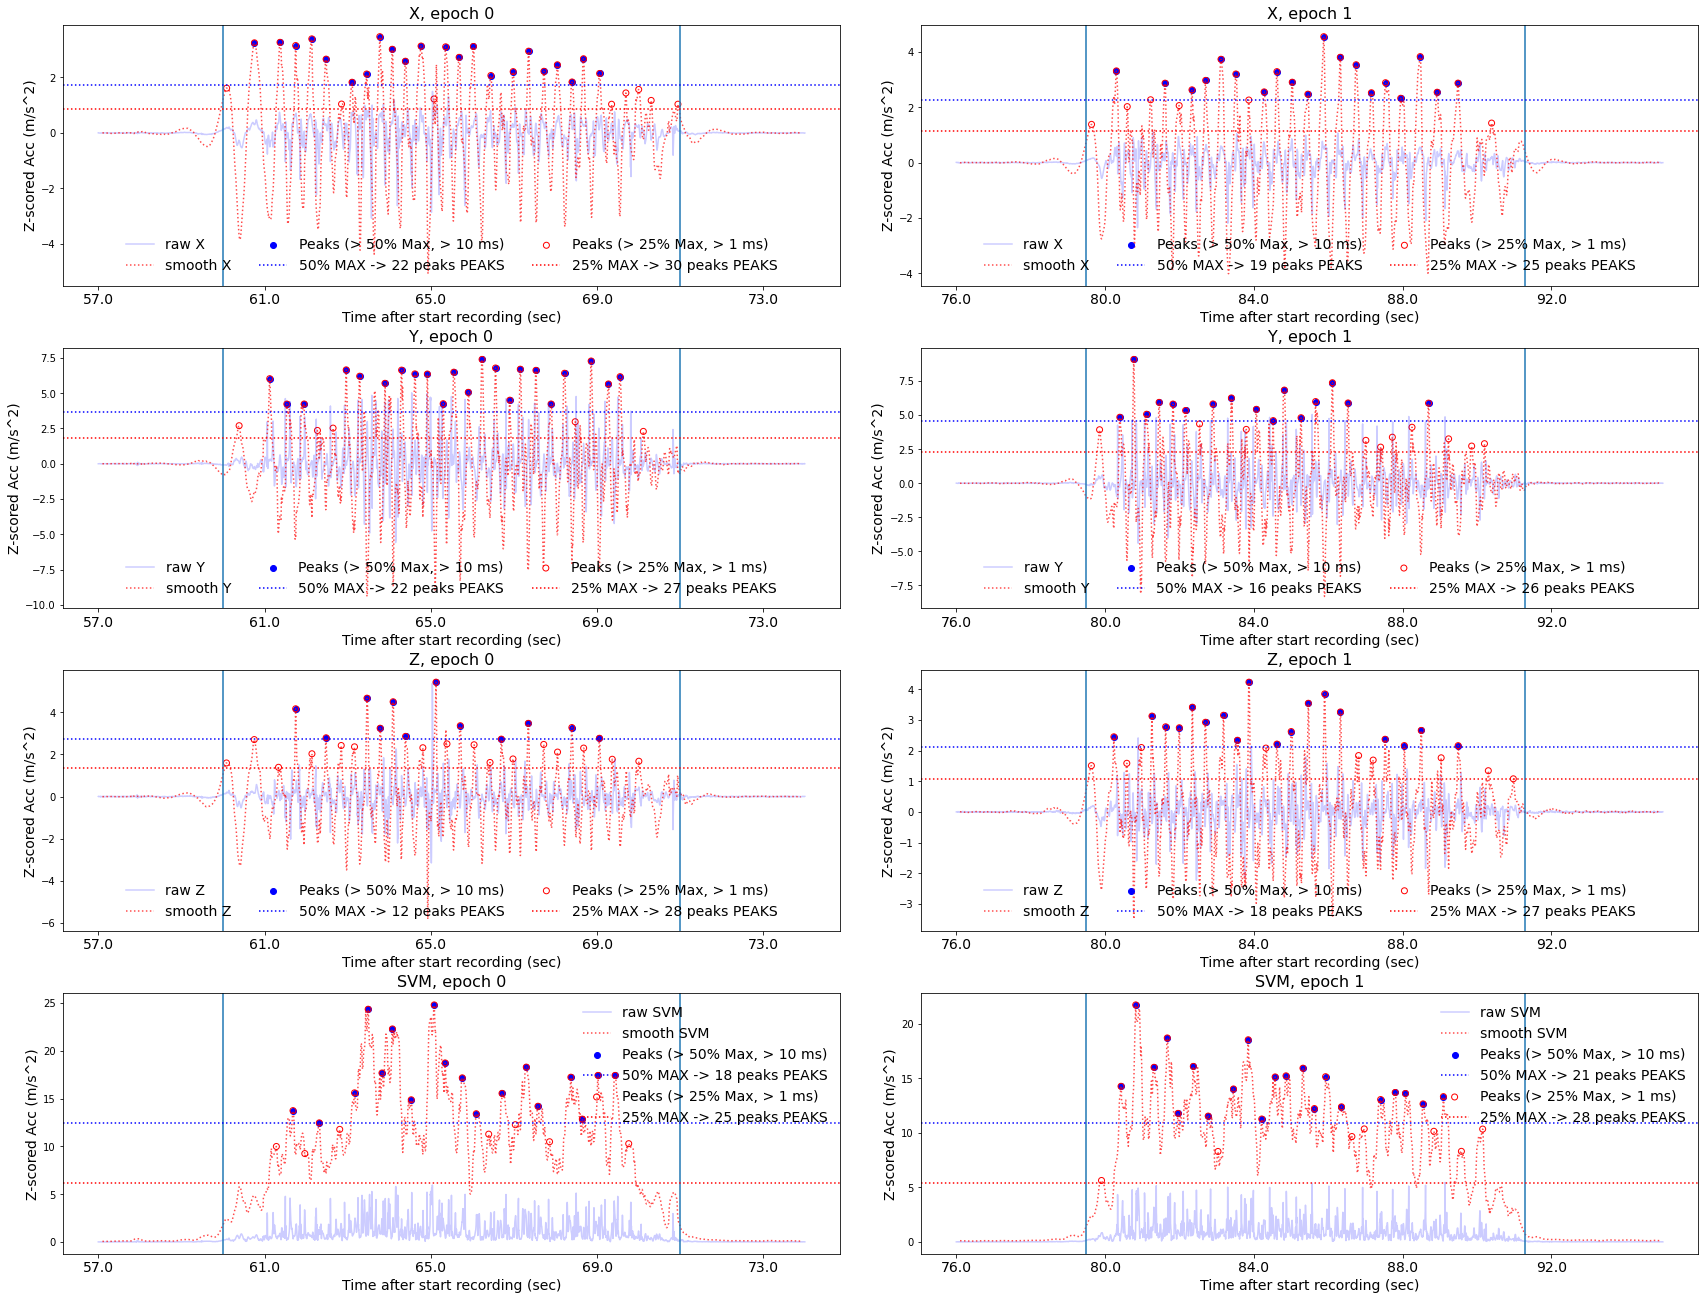

In [288]:
istart=[
    57*fs,  # epoch 0
    76*fs  # epoch 1
]
iend= [
    74*fs, # epoch 0
    95*fs, # epoch 1
]

tapstart = [
    60 * fs,  # epoch 0
    79.5 * fs  # epoch 1
]
tapend = [
    71 * fs,  # epoch 0
    91.3 * fs  # epoch 1
]
peak_clrs = ['blue', 'red']
# plt.plot(np.arange(istart, iend), acc[3, istart:iend], c='blue', alpha=.3, label='svm')
# plt.plot(np.arange(istart, iend), acc[1, istart:iend], c='red', alpha=.3, label='y')
fig,ax = plt.subplots(4,2, figsize=(24,18))
for i in [0, 1, 2, 3]:
    for e in [0, 1]:
        sig = acc[i, istart[e]:iend[e]]
        ax[i, e].plot(np.arange(istart[e], iend[e]), sig,
            alpha=.2, label=f'raw {names[i]}', c='blue')
        sigsmooth = pd.Series(sig).rolling(
            window=50, center=True).mean() * 10
        ax[i, e].plot(np.arange(istart[e], iend[e]), sigsmooth,
            alpha=.7, ls='dotted', label=f'smooth {names[i]}', c='red')

        ax[i, e].axvline(x=tapstart[e])
        ax[i, e].axvline(x=tapend[e])
        
        # smooth peaks
        thr = 50
        ms = 10
        
        xpeaks, peakdict = signal.find_peaks(
            sigsmooth,
            height=np.max(sigsmooth) * (thr/100),
            distance=fs / 4,  # ASSUMPTION: Max # taps per second
            width=(fs / 1000) * ms,  # ASSUMPTOIN: Min # millisec in tap
        )
        xpeaks = xpeaks + istart[e]
        ax[i, e].scatter(
            xpeaks, peakdict['peak_heights'], c=peak_clrs[0],
            label=f'Peaks (> {thr}% Max, > {ms} ms)',)
        ax[i, e].axhline(
            y=np.max(sigsmooth) * (thr/100),
            label=f'{thr}% MAX -> {len(xpeaks)} peaks PEAKS',
            ls='dotted', c=peak_clrs[0],
        )
        
        # smooth peaks #2
        thr = 25
        ms = 1
        xpeaks, peakdict = signal.find_peaks(
            sigsmooth,
            height=np.max(sigsmooth) * (thr/100),
            distance=fs / 4,  # ASSUMPTION: Max # taps per second
            width=(fs / 1000) * ms,  # ASSUMPTOIN: Min # millisec in tap
        )
        xpeaks = xpeaks + istart[e]
        ax[i, e].scatter(
            xpeaks, peakdict['peak_heights'],
            label=f'Peaks (> {thr}% Max, > {ms} ms)',
            color='none', edgecolor=peak_clrs[1],)
        ax[i, e].axhline(
            y=np.max(sigsmooth) * (thr/100),
            label=f'{thr}% MAX -> {len(xpeaks)} peaks PEAKS',
            ls='dotted', c=peak_clrs[1],
        )
        xticks = np.arange(istart[e], iend[e], fs * 4)
        ax[i, e].set_xticks(xticks)
        ax[i, e].set_xticklabels(xticks / fs, fontsize=14)
        ax[i, e].set_xlabel('Time after start recording (sec)',
            fontsize=14)
        ax[i, e].set_ylabel('Z-scored Acc (m/s^2)',
            fontsize=14)
        if i == 3: ax[i, e].legend(ncol=1, fontsize=14, loc='upper right', frameon=False)
        if i < 3: ax[i, e].legend(ncol=3, fontsize=14, loc='lower center', frameon=False)
        ax[i, e].set_title(f'{names[i]}, epoch {e}', size=16)
        # ax[i, e].set_ylim(-1, 13)
plt.tight_layout(pad=.5)
# plt.savefig(
#     os.path.join(temp_save, 'ACC', 'Acc_Barbara_s15_stimOff_medOn_Tapping_peakdetection'),
#     facecolor='white', dpi=150,
# )
plt.show()

# #####  COMPARE WITH VIDEO  #####
# synchronizer video: 00:04 - 00:06
# tapping right hand

# ### EPOCH 0
# handraise for first tap: 01:22
# handdown 1st tapping epoch video: 01:32
# 27 / 28 taps

# ### EPOCH 1
# handraise: 01:41, hand down 01:52
# tap start 01:42, tap stop 01:52
# 25 taps



### 1. Patient-Run Definition and Data Loading

#### Print available runs for subject and settings-version

In [5]:
# Explore available preprocessed runs
sub='008'
version='v2.0_Mar22'

importlib.reload(read_data)
read_data.show_runs(
    sub=sub,
    version=version,
    project_path=projectpath,
)


### SHOW RUNS ###
For subject 008, in preproc-version v2.0_Mar22 are available:

LFP_LEFT:
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa00']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa60']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa10']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa30']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa35']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa50']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa15']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa55']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa20']

LFP_RIGHT:
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa30']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa35']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa00']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa55']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa20']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa60']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa15']
['

#### Select and Load in runs to explore


Not defining task, acquisition or group results in selecting all available options

In [6]:
# Select runs to explore/ ft-extract
importlib.reload(read_data)
fsel, groups, fdir = read_data.select_runs(
    sub=sub,
    version=version,
    project_path=projectpath,
    sess_incl=['EcogLfpMedOn02'],
    tasks_incl=['SelfpacedHandTapL', 'Rest'],
    # acqs_incl=[
    # #     'StimOffDopa00',
    #     'StimOffDopa15',
    #     # 'StimOffDopa35',
    # #     'StimOffDopa50',
    # ],
    # groups_incl=['LFP_RIGHT', 'LFP_LEFT', 'ECOG'],  # if not given, all groups are included
)
# print and check selected runs
print(fsel)

['008_EcogLfpMedOn02_Rest_StimOffDopa00_1_v2.0_MAR22_LFP_LEFT_PREPROC_data.npy', '008_EcogLfpMedOn02_SelfpacedHandTapL_StimOffDopa60_1_v2.0_MAR22_LFP_LEFT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa30_1_v2.0_MAR22_LFP_RIGHT_PREPROC_data.npy', '008_EcogLfpMedOn02_SelfpacedHandTapL_StimOffDopa35_1_v2.0_MAR22_ECOG_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa10_1_v2.0_MAR22_LFP_LEFT_PREPROC_data.npy', '008_EcogLfpMedOn02_SelfpacedHandTapL_StimOffDopa35_1_v2.0_MAR22_ACC_RIGHT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa30_1_v2.0_MAR22_LFP_LEFT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa00_1_v2.0_MAR22_ACC_RIGHT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa10_1_v2.0_MAR22_ECOG_PREPROC_data.npy', '008_EcogLfpMedOn02_SelfpacedHandTapL_StimOffDopa35_1_v2.0_MAR22_LFP_LEFT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa30_1_v2.0_MAR22_ACC_RIGHT_PREPROC_data.npy', '008_EcogLfpMedOn02_Rest_StimOffDopa50_1_v2.0_MAR22_LFP_LEFT_PREPROC_da

In [7]:
# Create dataclass per session
# session-dataclass wil contain dict with dataclasses containing
# data per run
importlib.reload(read_data)
SUB08 = read_data.SessionData(fsel, fdir)
# RERUN ACC PREPROC WITH Fs 200 because of Nyquist and windowing in half seconds


In [ ]:
'''
PM: CREATE CLASS WITH WINDOWED FEATURES (EVERY 0.5 / 1 SEC, WITH 50% OVERLAP)

- WINDOWING BASED ON CURRENT SAMPLE-FREQ OF DATATYPE
- IN FT EXTRACTION PROCESS: ADDITIONAL FILTERING BEFORE WINDOWING!
- ADD CLASS WITH VIDEO-BASED EVENT RECOGNITION
    - dysk occurence:
        - coded for bodypart
        - coded for severity?
    - normal movement?
'''

In [886]:
arr3d = windowing_2d_data(
    dclass=SES, run='Rest_StimOffDopa10',
    source='acc_left', win_time=1.28,
    art_removal=True,
)  # use to fill new dataclass? (incl mean and std per window
# for artifact removal etc?)
# PM event-based dataclass, only selecting windows before after
# movement events (voluntary vs dyskinesia)

start 3d removal


#### Manual Video-Movement Annotation

In [37]:
# annotate observed taps in video, integers are seconds
# from video start
# CAVE: orignal Video-starttime is hour in front
# values here are corrected one hour backwards (12->11)
# Still the video-time seems to be +/- 3 minutes behind
# the acc-neurophys-time
taptimes_video = {
    'SelfpacedHandTapL_StimOffDopa15': {
        'left': [
            1154, 1160, 1164, 1169, 1174, 1180, 1185,
            1191, 1195, 1201, 1207, 1226, 1238, 1243,
            1248, 1253
        ],
        'right':[
            1260, 1264, 1270, 1275, 1281, 1290, 1298,
            1303, 1308, 1313, 1320, 1324, 1332, 1339,
            1345
        ],
        'starttime': '2021-11-15 11:29' 
        # original 11:26 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa35': {
        'left': [
            878, 883, 888, 893, 898, 903, 908, 915,
            919, 926, 933, 946, 951, 957, 963, 970,
            976, 984
        ],
        'right':[
            1000, 1006, 1011, 1017, 1024, 1028, 1035,
            1041, 1054, 1060, 1081, 1089, 1097, 1103,
            1108
        ],
        'starttime': '2021-11-15 11:51:01'
        # original 11:48 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa60': {
        'left': [
            641, 647, 652, 657, 662, 666, 671, 676,
            682, 686, 692, 697, 703, 708, 713, 719,
        ],
        'right':[
            726, 730, 734, 740, 746, 751, 756, 761,
            768, 773, 779, 784, 792, 797, 801
        ],
        'starttime': '2021-11-15 12:22:59'
        # original 12:20 but corrected for mismatching times
    }
}
# add timedelta in seconds to start-time of video
# CAVE videostarttime is on MINUTE-RESOLUTION
# thus will be SECONDS OF FROM ACC-TIMESTAMP
for run in taptimes_video:
    starttime = pd.Timestamp(taptimes_video[run]['starttime'])
    for side in ['left', 'right']:
        taptimes_video[run][f'{side}_stamps'] = []
        for sec in taptimes_video[run][side]:
            delta = pd.Timedelta(sec, 'sec')
            taptimes_video[run][f'{side}_stamps'].append(
                starttime + delta)

# Save annotation dict
# deriv_dir = os.path.join(
#     projectpath, 'data', 'analysis_derivatives', 'sub-008', 'taps'
# )
# dict_name = f'008_video_ann_tapruns'
# np.save(os.path.join(deriv_dir, dict_name),
#         taptimes_video)

# # Load annotation dict
# video_taps = np.load(os.path.join(deriv_dir, f'{dict_name}.npy'),
#                      allow_pickle=True).item()


#### Automated Acc-based Tap detection incl. plotting

In [8]:
SUB08.runs_incl

['Rest_StimOffDopa00',
 'SelfpacedHandTapL_StimOffDopa60',
 'Rest_StimOffDopa30',
 'SelfpacedHandTapL_StimOffDopa35',
 'Rest_StimOffDopa10',
 'Rest_StimOffDopa50',
 'SelfpacedHandTapL_StimOffDopa15']

In [11]:
importlib.reload(handTap_detect)


<module 'lfpecog_features.handTap_detect' from '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/lfpecog_features/handTap_detect.py'>

In [272]:
importlib.reload(handTap_detect)
# define file with manual video-annotations
tap_ann_file = os.path.join(
    projectpath, 'data', 'analysis_derivatives', 'sub-008',
    'taps', '008_video_ann_tapruns.npy')
# run function
blocks = handTap_detect.handTapDetector(
    SubClass=SUB08,
    check_plots=False,
    # check_plots=False,
    runs_excl=[
#         'Rest_StimOffDopa00', 'Rest_StimOffDopa30',
#  'SelfpacedHandTapL_StimOffDopa35',
#  'Rest_StimOffDopa10',
#  'Rest_StimOffDopa50',
#  'SelfpacedHandTapL_StimOffDopa15'
    ],
    plotdir=os.path.join(temp_save, 'ACC'),
    plot_annot=tap_ann_file,
    buffsec=.05,
    TAPthr=2e-7,
    MOVthr=1e-7,
    savedir=os.path.join(
        projectpath, f'data/preprocess/sub-{sub}/'
        f'/acc/acc_taps_sub{sub}'),
)


Start Rest_StimOffDopa00

Start SelfpacedHandTapL_StimOffDopa60

Start Rest_StimOffDopa30

Start SelfpacedHandTapL_StimOffDopa35

Start Rest_StimOffDopa10

Start Rest_StimOffDopa50

Start SelfpacedHandTapL_StimOffDopa15


In [267]:
for run in [
    'SelfpacedHandTapL_StimOffDopa15',
    'SelfpacedHandTapL_StimOffDopa35',
    'SelfpacedHandTapL_StimOffDopa60'
]:
    print(run)
    for side in ['left', 'right']:
        print([len(blocks[run][side]['Taps'][k]) for k in
            blocks[run][side]['Taps']])

SelfpacedHandTapL_StimOffDopa15
[130, 124, 116, 130, 110, 94, 76, 111, 76, 79, 77, 99, 87, 84, 87, 91]
[137, 168, 116, 137, 126, 128, 95, 113, 114, 122, 118, 120, 116, 120, 92]
SelfpacedHandTapL_StimOffDopa35
[107, 111, 102, 82, 84, 88, 78, 99, 103, 166, 119, 60, 99, 113]
[128, 178, 122, 97, 129, 100, 110, 116, 118, 171, 66, 101, 188, 156, 131, 123, 167]
SelfpacedHandTapL_StimOffDopa60
[162, 130, 116, 105, 116, 115, 109, 94, 117, 137, 114, 100, 116, 74, 112]
[165, 165, 138, 149, 118, 139, 132, 132, 127, 123, 116, 175, 121, 146, 142]


In [177]:
a = np.array([5555 , 6600, 7000])
a / 200

array([27.775, 33.   , 35.   ])

In [263]:
# Plot figures to check identified acticity blocks per block

blockdict = blocks
for run in [
    'SelfpacedHandTapL_StimOffDopa15',
    'SelfpacedHandTapL_StimOffDopa35',
    'SelfpacedHandTapL_StimOffDopa60'
]:
    nrows=20
    thr = 5e-7
    fig, axes = plt.subplots(nrows, 2, figsize=(16,12),
        sharey='row',)
    # axes = axes.flatten()
    ls = {'left': 'solid', 'right': 'dotted'}
    state='Taps'
    xdiff = 100

    for s, accside in enumerate(['left', 'right']):
        runclass = SUB08.runs[run]
        acc_svm = np.sqrt(
            getattr(runclass, f'acc_{accside}_arr')[1, :]**2 +
            getattr(runclass, f'acc_{accside}_arr')[2, :]**2 +
            getattr(runclass, f'acc_{accside}_arr')[3, :]**2
        )

        for b in np.arange(nrows):
            try:
                acc0 = int(blockdict[run][accside][state][b][0] * 200)
            except KeyError:
                for sp in ['left', 'right', 'top', 'bottom']:
                    axes[b, s].spines[sp].set_visible(False)
                axes[b, s].set_ylabel(f'{b}', size=14)
                axes[b, s].set_xticks([])
                axes[b, s].set_yticks([])
                continue
            acc1 = int(blockdict[run][accside][state][b][-1] * 200)
            axes[b, s].plot(acc_svm[acc0 - xdiff:acc1 + xdiff],
                alpha=.5, label=accside)
            axes[b, s].axvline(x=xdiff)
            axes[b, s].axvline(x=xdiff + acc1 - acc0)
            axes[b, s].set_yticklabels([])
            if s == 0: axes[b, s].set_ylabel(f'{b}', size=14)
            for a in ['right', 'top']:
                axes[b, s].spines[a].set_visible(False)
        axes[0, s].set_title(f'{accside.upper()}', size=14)

    plt.suptitle(run, color='gray', size=14)
    plt.tight_layout(h_pad=0.0, w_pad=0.0)
    fig.savefig(os.path.join(
        temp_save, 'ACC',
        f'single_{state}_sub08_{run[-6:]}_LR_v4'
    ), dpi=150, facecolor='w',)
    plt.close()

    #### TODO:
    ### New Tap detection:
    ## USE Y-axis
    ## SEARCH for double sinusoid for one tap (+ - - +)
    #   one sinusoid (+ -) is raising hand
    #   one sinusoid (- +) is lowering hand
    # PM: use impact-artifact as backup-tap detection
    # - SPLIT THRESHOLDS FOR TAP DETECT VS DYSK/ELSE DETECT
    # - ANNOTATE VIDEO WITH DYSKINETIC MOVEMENTS TO CHECK NEW ALGORITHM

In [ ]:
'''
IMPORTANT: CHECK VIDEO - TMSi TIME DIFF
# second left-mov (tap) in video at 19:19
# -> video Timestamp('2021-11-15 11:45:20')
# -> acc from 2021-11-15 11:48:19.395000 
#           to 2021-11-15 11:48:20.300000

# first right-mov (dysk) in video at 19:14
#  -> video Timestamp('2021-11-15 11:47:00')
#  -> acc from 2021-11-15 11:48:14.505000
#           to 2021-11-15 11:48:16.040000

# Rest recording starts in video at 12:52
# -> video first movements right between 13:00 +/- 00:02:
#   stamp is 11:26:00 + 00:13:00 -> 11:39:00 +/- 00:02
# IN ACC: 11:42:00 +/- 00:02
# ERGO: For Rest10, Tapping15: ACC-time is 03:00 ahead of Video

## TODO / Finish:
- PREPROC: INCLUDE TIME (t) and TimeSTAMPS (ts) to arrays
- PREPROC: downssample to higher freq for short term analyssi
- differentiation in algorithm between dyskinetic movement and tap
- test algorithm on different Subjects



## Test py_nmd Batch

In [23]:
# # import py_neuromodulation after defining relevant directories
# from py_neuromodulation import nm_BidsStream, nm_analysis
# os.chdir(os.path.join(projectpath, 'code', 'py_neuromodulation'))
# import scripts.pynm_batch_processing as pynmd_batch
# os.chdir(projectpath)

In [32]:
# importlib.reload(pynmd_batch)
# npyfile = ('008_EcogLfpMedOn02_SelfpacedHandTapL_StimOffDopa60'
#         '_1_v2.0_MAR22_LFP_RIGHT_PREPROC_data.npy')
# npyfile = os.path.join(projectpath, 'code', 'py_neuromodulation',
#     'scripts', npyfile)
# batch = pynmd_batch.main(npyfile)

### took 24 min and kernel died

No Error occurred when testing the settings.


### 2. Explore spectral domain: Try out wavelet

In [224]:
def normalize(data, meth: str):
    '''
    Arguments:
        - 3d array [windows, rows, time]
        - meth: method: nrm or std: 
        normalization
            [min - max] = [0 - 1];
        standardization
            [-2sd, +2sd] = [-2, 2]
    '''
    if len(data.shape) == 3:  # 3d-array
        for w in range(data.shape[0]):
            if meth == 'std':
                m = np.nanmean(data[w, :, :])
                s = np.nanstd(data[w, :, :])
                data[w, :, :] = (data[w, :, :] - m) / s
            elif meth == 'nrm':
                mx = np.nanmax(data[w, :, :])
                data[w, :, :] = data[w, :, :] / mx

    elif len(data.shape) == 2:  # 2d-array
        if meth == 'std':
            m = np.nanmean(data[:, :])
            s = np.nanstd(data[:, :])
            data[:, :] = (data[:, :] - m) / s
        elif meth == 'nrm':
            mx = np.nanmax(data[:, :])
            data[:, :] = data[:, :] / mx

    return data

In [506]:
def psds_mov_nomov_blocks(
    subClass, runblocks, run, lfpside, accside,
    row: int, nseg: int = 512,
):
    '''
    PSD (welch) of only movement-detected blocks
    no diff yet between dyskinesia and fingertap
    '''
    # run = 'SelfpacedHandTapL_StimOffDopa60'
    # side = 'left'
    # row = 4
    # nseg = 512

    act_arr = np.zeros((nseg))
    for b in runblocks[run][accside]:
        b_start = runblocks[run][accside][b][0]
        b_len = len(runblocks[run][accside][b]) / getattr(
            subClass.runs[run], f'acc_{accside}_Fs')  # len in sec
        # find index of start of block in time-array
        istart = np.where(getattr(subClass.runs[run],
                f'lfp_{lfpside}_arr')[0] == b_start)[0][0]
        for i in np.arange(1, 4.1, .5):
            # takes as many 512-blocks as fit in mov-blocks (5-% overlap)
            if b_len >= (nseg / 1000) * i:
                act_arr = np.vstack((act_arr, getattr(
                    subClass.runs[run], f'lfp_{lfpside}_arr'
                    )[row, istart + int(nseg * (i - 1)):istart + int(
                    nseg * i)]
                ))

    noact_arr = np.zeros((nseg))
    for b in runblocks[run][accside]:
        if b == 0:
            noact_len = runblocks[run][accside][b][0]
            b_start = 0  # first no-act block starts at 0
        else:
            b_start = runblocks[run][accside][b - 1][-1]
            noact_len = (runblocks[run][accside][b][0] - b_start) / 200
        # find index of end of last block in time-array
        istart = np.where(getattr(subClass.runs[run],
                f'lfp_{lfpside}_arr')[0] == b_start)[0][0]
        for i in np.arange(1, 100, .5):
            # takes as many 512-blocks as fit in mov-blocks (5-% overlap)
            if noact_len >= ((nseg / 1000) * i):
                # try:
                noact_arr = np.vstack((noact_arr, getattr(
                    subClass.runs[run], f'lfp_{lfpside}_arr'
                    )[row, istart + int(nseg * (i - 1)):istart + int(
                    nseg * i)]
                ))
                # except ValueError:
                #     print(b, i, noact_len, int(nseg * i))
    # for whole 3d block stacking use np.vstack()
    act_arr = np.delete(act_arr, 0, axis=0)  # delete empty start row
    f, actpsd = signal.welch(act_arr, axis=1, fs=800, nperseg=512)
    actpsd = np.nanmean(actpsd, axis=0)  # take mean PSD over all windows
    # plt.plot(np.log10(f), np.log10(psd), c='blue', label='Movement')

    noact_arr = np.delete(noact_arr, 0, axis=0)  # delete empty start row
    f, noactpsd = signal.welch(noact_arr, axis=1, fs=800, nperseg=512)
    noactpsd = np.nanmean(noactpsd, axis=0)  # take mean PSD over all windows
    # plt.plot(np.log10(f), np.log10(psd), c='orange', label='No movement')
    # plt.xlim(0, 2.4)
    # plt.legend()
    # plt.show()
    return f, actpsd, noactpsd

In [665]:
## RUN BASE FUNCTION
importlib.reload(specBase)
base = specBase.EphyBase(
    runClass=SUB08, runname=run,
)


In [273]:
import lfpecog_features.feats_spectral_features as specFts


In [285]:
importlib.reload(specFts)
run='SelfpacedHandTapL_StimOffDopa15'
specFts.extractSpectralFts(
    runClass=SUB08[run],
    ft_params=[],
)


end of class, 


ValueError: mutable default <class 'list'> for field ft_params is not allowed: use default_factory

(0.0, 100.0)

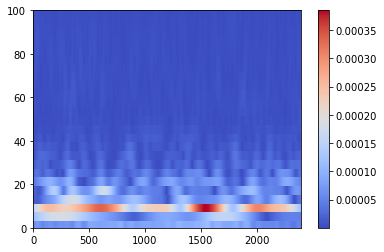

In [773]:
### SPECTRAL CHECK OF CREATED BASE PERIODS
dtype='ecog'
chname='ECOG_L_1'
fig,ax = plt.subplots(1,1)
im = ax.pcolormesh(
    getattr(getattr(newbase, dtype), chname).wav['time'],
    getattr(getattr(newbase, dtype), chname).wav['freq'],
    getattr(getattr(newbase, dtype), chname).wav['psd'],
    cmap='coolwarm',
)
cbar = fig.colorbar(im, ax=ax)
plt.ylim(0, 100)



In [761]:
# newbase.ecog.ECOG_L_1.wavlog['psd']
ephybase = getattr(newbase, 'lfp_right')
chbase = getattr(ephybase, chname)
chbase.__dict__.keys()

dict_keys(['level', 'rawsig', 'psd_512', 'psd_256', 'wav', 'wavlog'])

CH 1;	ephy_ch {'ecog': 1, 'lfp_left': 4, 'lfp_right': 2} -> ECOG_L_1
Acc samples block 7: 210
CH 4;	ephy_ch {'ecog': 1, 'lfp_left': 4, 'lfp_right': 2} -> LFP_L_3_4
Acc samples block 7: 210
CH 2;	ephy_ch {'ecog': 1, 'lfp_left': 4, 'lfp_right': 2} -> LFP_R_3_4
Acc samples block 7: 210


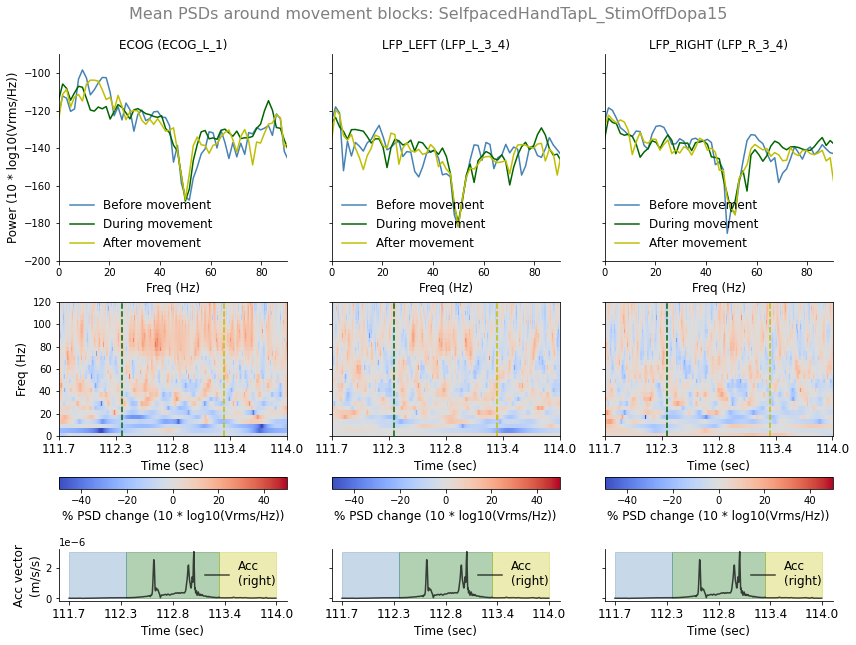

In [807]:
fig, axes = plt.subplots(
    3, 3, figsize=(12, 9),
    sharey='row',
    gridspec_kw={'height_ratios': [4, 4, 1]})
ts=12
# levels with most beta/gamma roughly:
# ECOG 1; LFP_R: 2-3, 4-5; LFP_L: 1-2, 2-3, 3-4
ephy_ch = {'ecog': 1, 'lfp_left': 4, 'lfp_right': 2}
nsegs = 512
halfseg  = nsegs // 2

runpsds = np.zeros((1, halfseg + 1))  # store ephys windows
prepsds = np.zeros((1, halfseg + 1))
postpsds = np.zeros((1, halfseg + 1))
accside = 'right'
# lfpside = 'lfp_left'
ephys_fs = getattr(SUB08.runs[SUB08.runs_incl[0]],
    f'ecog_Fs')
acc_fs = getattr(SUB08.runs[SUB08.runs_incl[0]],
    f'acc_{accside}_Fs')

accsegs = int(nsegs / ephys_fs * acc_fs)
runaccs = np.zeros((1, accsegs))  # store acc windows

clrs = {
    'Before': 'steelblue',
    'During': 'darkgreen',
    'After':'y'
}
fillparams = {
    'Before': {'color': 'none', 'hatch': '//',
            'edgecolor': clrs['Before'],'alpha': .8,},
    'During': {'color': clrs['During'], 'alpha': .1,},
    'After': {'color': 'none', 'hatch': '\\',
            'edgecolor': clrs['After'],'alpha': .8,},
}
run = 'SelfpacedHandTapL_StimOffDopa15'
for i in np.arange(10):
    for col, ephys in enumerate([
        'ecog',
        'lfp_left',
        'lfp_right'
    ]):
        RUN = SUB08.runs[run]
        ch = ephy_ch[ephys]
        chname = getattr(RUN,
            f'{ephys}_names')[ch]
        print(f'CH {ch};\tephy_ch {ephy_ch} -> {chname}')
        # epoch artefact baselines for run
        runmean = np.mean(getattr(RUN,
            f'{ephys}_arr')[ch, :])
        runstd = np.std(getattr(RUN,
            f'{ephys}_arr')[ch, :])
        SD4 = runmean + runstd * 4  # threshold sd4
        
        # calculate acc signal vector magn for run
        acc_svm = np.sqrt(
            getattr(RUN, f'acc_{accside}_arr')[1, :]**2 +
            getattr(RUN, f'acc_{accside}_arr')[2, :]**2 +
            getattr(RUN, f'acc_{accside}_arr')[3, :]**2
        )

        i = 7  # SELECT MOV-BLOCK TO PLOT

        print(f'Acc samples block {i}: {len(runblocks[run][accside][i])}')
        # take start (end) in Acc-blocks
        accstart = runblocks[run][f'{accside}'][i][0]
        # find corresponding timestamp in ephys
        ephystart = np.where(getattr(RUN, f'{ephys}_arr')[
            0, :] == accstart)[0][0]
        accend = runblocks[run][f'{accside}'][i][-1]
        ephyend = np.where(getattr(RUN, f'{ephys}_arr')[
            0, :] == accend)[0][0]
        blockacc = acc_svm[
            int(accstart * acc_fs) - accsegs:
            int(accend * acc_fs) + accsegs
        ]  # selects acc for mov block + segm pre/post
        movdat = getattr(RUN, f'{ephys}_arr')[
            ch, ephystart:ephyend]
        predat = getattr(RUN, f'{ephys}_arr')[
            ch, ephystart - nsegs:ephystart]
        postdat = getattr(RUN, f'{ephys}_arr')[
            ch, ephyend:ephyend + nsegs]
        wavdat = getattr(RUN, f'{ephys}_arr')[
            ch, ephystart - nsegs:ephyend + nsegs]
        wavtime = getattr(RUN, f'{ephys}_arr')[
            ch, ephystart - nsegs:ephyend + nsegs]
        # artefact check
        if np.any([
            np.any(movdat > SD4),
            np.any(postdat > SD4),
            np.any(predat > SD4),
        ]):
            print(f'ARTEFACT: Skip block {i} from '
                    f'{ephys} {run}')
            continue  # skip block

        fs, movpsd = signal.welch(
            movdat,
            fs=ephys_fs,
            nperseg=nsegs, noverlap=halfseg,  #axis=1,
        )  # create arr with welch-psd per window in block
        fs, prepsd = signal.welch(
            predat,
            fs=ephys_fs,
            nperseg=nsegs, noverlap=halfseg,
        )
        fs, postpsd = signal.welch(
            postdat,
            fs=ephys_fs,
            nperseg=nsegs, noverlap=halfseg,
        )

        ### Plot PSD of active blocks in Run
        for label, psd_arr in zip(
            ['Before', 'During', 'After'],
            [prepsd, movpsd, postpsd]  # removed 2d-psds
        ):
            axes[0, col].plot(
                fs, 10 * np.log10(psd_arr), label=f'{label} movement',
                c=clrs[label],
            )
        axes[0, col].set_xlabel('Freq (Hz)', size=ts,)
        if col == 0:
            axes[0, col].set_ylabel('Power (10 * log10(Vrms/Hz))', size=ts,)
        axes[0, col].set_xlim(0, 90)
        axes[0, col].set_ylim(-200, -90)
        axes[0, col].set_title(f'{ephys.upper()} ({chname})')
        axes[0, col].legend(
            ncol=1, frameon=False, loc='lower left', fontsize=ts,)
        axes[0, col].spines['right'].set_visible(False)
        axes[0, col].spines['top'].set_visible(False)

        ### Wavelet Decomposition
        w = 8  # depth/spaces?
        wav_f = np.linspace(1, ephys_fs / 2, 100)
        widths = (ephys_fs * w) / (2 * wav_f * np.pi)
        wav_t = np.arange(len(wavdat))
        scp_cfs = signal.cwt(
            wavdat, signal.morlet2, widths=widths,
            w=w, dtype='complex128'
        )
        wavpsd = np.abs(scp_cfs)
        logwavpsd = 10 * np.log10(wavpsd)
        ephybase = getattr(newbase, ephys)
        wavbase = 10 * getattr(ephybase, chname).wavlog['psd']
        wavpsd = logwavpsd - wavbase[:, :logwavpsd.shape[1]]  # absolute
        wavpsd = (wavpsd / np.abs(wavbase[:, :logwavpsd.shape[1]])) * 100  # %
        # Plot change vs base of time-spectral wavelet decomp
        im = axes[1, col].pcolormesh(
            wav_t, wav_f, wavpsd,
            cmap='coolwarm',
            # vmin=-5, vmax=5,  # absolute
            vmin=-50, vmax=50,  # percentage
        )
        cbar = fig.colorbar(
            im, ax=axes[1, col], 
            location='bottom', pad=.2,)
        cbar.set_label('% PSD change (10 * log10(Vrms/Hz))', size=ts,)
        # Plot details
        # axes[1, col].set_title(f'{ephys} psd change vs baseline')
        axes[1, col].set_ylim(0, 120)
        axes[1, col].set_xlabel('Time (sec)', size=ts,)
        axes[1, col].set_xticks(np.linspace(
            wav_t[0], wav_t[-1], 5
        ))
        axes[1, col].set_xticklabels(np.round(np.linspace(
            ephystart - nsegs, ephyend + nsegs, 5) / ephys_fs, 1),
            size=ts,)
        if col == 0: axes[1, col].set_ylabel('Freq (Hz)', size=ts,)
        # add Acc-line in Time-Freq plot
        axes[1, col].axvline(
            x=wav_t[nsegs], color=clrs['During'], ls='dashed',)
        axes[1, col].axvline(
            x=wav_t[-nsegs], color=clrs['After'], ls='dashed',)

        ### Plot mean signal vector for ACC
        axes[2, col].plot(
            np.arange(
                (accstart * acc_fs) - accsegs,
                (accend * acc_fs) + accsegs
            ), blockacc,
            label=f'Acc\n({accside})',
            c='k', alpha=.7,
        )
        maxsvm = np.max(blockacc)
        axes[2, col].fill_betweenx(
            y=np.linspace(0, maxsvm, 10),
            x1=accstart * acc_fs, x2=accend * acc_fs,
            color=clrs['During'], alpha=.3,
        )
        axes[2, col].fill_betweenx(
            y=np.linspace(0, maxsvm, 10),
            x1=accstart * acc_fs - accsegs,
            x2=accstart * acc_fs,
            color=clrs['Before'], alpha=.3,
        )
        axes[2, col].fill_betweenx(
            y=np.linspace(0, maxsvm, 10),
            x1=accend * acc_fs,
            x2=accend * acc_fs + accsegs,
            color=clrs['After'], alpha=.3,
        )

        xticks = np.linspace(
            (accstart * acc_fs) - accsegs,
            (accend * acc_fs) + accsegs, 5
        )
        axes[2, col].set_xticks(xticks)
        axes[2, col].set_xticklabels(
            np.round(xticks / acc_fs, 1),
            size=ts,)
        axes[2, col].set_xlabel('Time (sec)', size=ts,)
        if col == 0: axes[2, col].set_ylabel(
            'Acc vector\n(m/s/s)', size=ts,)
        axes[2, col].legend(
            ncol=1, frameon=False, loc='upper right', 
            # bbox_to_anchor=(0.8, -.05)
            fontsize=ts,
        )
        axes[2, col].spines['right'].set_visible(False)
        axes[2, col].spines['top'].set_visible(False)


    title = (f'Mean PSDs around movement blocks: {run}')
    plt.suptitle(title, size=16, x=.5, y=.99, c='gray')
    plt.tight_layout(h_pad=.3)
    fname = f'Mean_PSDs_aroundMov_EcogLfps_Ex_Dopa15_{i}_percCh2'
    fig.savefig(os.path.join(temp_save, fname),
        facecolor='white', dpi=150,)
    plt.close()

#


In [797]:
print(accend, accstart)

113.37 112.325


In [801]:
wav_t.shape[0] / 800

2.325

/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_24487/64058387.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(fx), np.log10(psx))


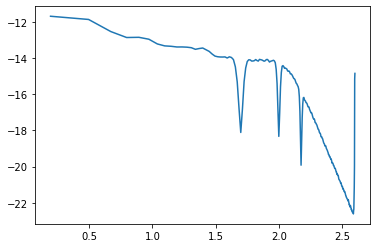

In [138]:
fx, psx = signal.welch(
    SUB08.runs['Rest_StimOffDopa00'].lfp_left_arr[1][
        4000:52000],
    fs=SUB08.runs['Rest_StimOffDopa00'].lfp_left_Fs,
    nperseg=512, noverlap=256,
)
plt.plot(np.log10(fx), np.log10(psx))
# plt.xlim(0, 120)
plt.show()

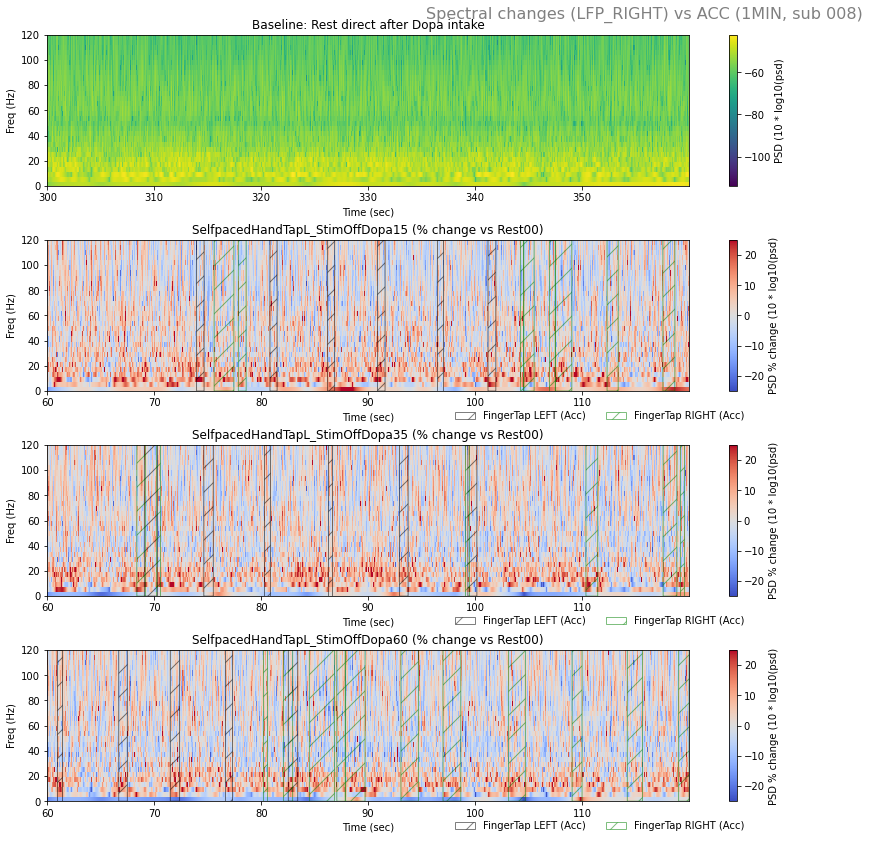

In [223]:
'''
Plot BASE 00, then Selfp over time corrected for BASE
'''


plotruns = [
    'SelfpacedHandTapL_StimOffDopa15',
    'SelfpacedHandTapL_StimOffDopa35',
    'SelfpacedHandTapL_StimOffDopa60'
]
datasource = 'lfp_right'
clrs = {'left': 'k', 'right': 'green'}

fig, axes = plt.subplots(len(plotruns) + 1, 1, figsize=(12, 12))

base = SUB08.runs['Rest_StimOffDopa00']
Fs_lfp = getattr(base, f'{datasource}_Fs')
Fs_acc = base.acc_left_Fs
istart = 60 * Fs_lfp
istop = 120 * Fs_lfp

basestart = 300 * Fs_lfp  # first minute no rest
basestop = 360 * Fs_lfp
basetime = getattr(base, f'{datasource}_arr')[
    0, basestart:basestop]
basesig = getattr(base, f'{datasource}_arr')[
    1, basestart:basestop]

# Plot BASE
w = 8  # depth/spaces?
base_f = np.linspace(1, Fs_lfp / 2, 100)
widts = (Fs_lfp * w) / (2 * base_f * np.pi)
# mor = signal.morlet2(M=100, s=4, w=2)
scp_cfs = signal.cwt(
    basesig, signal.morlet2, widths=widts,
    w=w, dtype='complex128')
scp_psd = np.abs(scp_cfs)
baselogpsd = 10 * np.log10(scp_psd)

im = axes[0].pcolormesh(
    basetime, base_f, baselogpsd,
    cmap='viridis'
)
cbar = fig.colorbar(im, ax=axes[0], )
cbar.set_label('PSD (10 * log10(psd)')
axes[0].set_title('Baseline: Rest direct after Dopa intake')
axes[0].set_ylabel('Freq (Hz)')


# Plot Tap Runs
for ax, run in enumerate(plotruns):
    sig=getattr(SUB08.runs[run],
        f'{datasource}_arr')[1, istart:istop]
    time=getattr(SUB08.runs[run],
        f'{datasource}_arr')[0, istart:istop]

    # SCIPY WAVELET
    scp_cfs = signal.cwt(
        sig, signal.morlet2, widths=widts,
        w=w, dtype='complex128')
    scp_psd = np.abs(scp_cfs)
    logpsd = 10 * np.log10(scp_psd)
    changepsd = ((logpsd - baselogpsd) / baselogpsd) * 100

    im = axes[ax + 1].pcolormesh(
        time, base_f, changepsd,
        cmap='coolwarm', vmin=-25, vmax=25,
    )
    cbar = fig.colorbar(im, ax=axes[ax + 1], )
    cbar.set_label('PSD % change (10 * log10(psd)')

    axes[ax + 1].set_title(f'{run} (% change vs Rest00)')
    axes[ax + 1].set_ylabel('Freq (Hz)')

    if run in runblocks.keys():
        for side in ['left', 'right']:
            for movb in runblocks[run][side]:
                if movb == 0:
                    axes[ax + 1].fill_between(
                        y1=0,
                        y2=120,
                        x=time,
                        where=np.logical_and(
                            runblocks[run][side][movb][0] < time,
                            time < runblocks[run][side][movb][-1]),
                        color='none', alpha=.5, hatch='/',
                        edgecolor=clrs[side],
                        label = f'FingerTap {side.upper()} (Acc)',
                    )
                else:
                    axes[ax + 1].fill_between(
                        y1=0,
                        y2=120,
                        x=time,
                        where=np.logical_and(
                            runblocks[run][side][movb][0] < time,
                            time < runblocks[run][side][movb][-1]),
                        color='none', alpha=.5, hatch='/',
                        edgecolor=clrs[side],
                    )
        axes[ax + 1].legend(loc='upper right',
            bbox_to_anchor=(1.1, -.07),
            frameon=False, ncol=2,
        )
                

for ax in axes:
    ax.set_ylim(0, 120)
    ax.set_xlabel('Time (sec)')
fname = (f'Spectral changes ({datasource.upper()}) '
         f'vs ACC (1MIN, sub {SUB08.runs[run].sub})')
plt.suptitle(
    fname,
    color='gray', x=.75, y=.97, size=16)
plt.tight_layout(w_pad=.001, h_pad=.5)
plt.savefig(os.path.join(temp_save, fname),
    dpi=150, facecolor='w',)
plt.show()

In [ ]:
run = 'SelfpacedHandTapL_StimOffDopa60'
side = 'left'
taptimes_video[run][f'{side}_stamps']

[Timestamp('2021-11-15 12:33:40'),
 Timestamp('2021-11-15 12:33:46'),
 Timestamp('2021-11-15 12:33:51'),
 Timestamp('2021-11-15 12:33:56'),
 Timestamp('2021-11-15 12:34:01'),
 Timestamp('2021-11-15 12:34:05'),
 Timestamp('2021-11-15 12:34:10'),
 Timestamp('2021-11-15 12:34:15'),
 Timestamp('2021-11-15 12:34:21'),
 Timestamp('2021-11-15 12:34:25'),
 Timestamp('2021-11-15 12:34:31'),
 Timestamp('2021-11-15 12:34:36'),
 Timestamp('2021-11-15 12:34:42'),
 Timestamp('2021-11-15 12:34:47'),
 Timestamp('2021-11-15 12:34:52'),
 Timestamp('2021-11-15 12:34:58')]

In [ ]:
['',
 'SelfpacedHandTapL_StimOffDopa60',
 
 'SelfpacedHandTapL_StimOffDopa35',
 'SelfpacedHandTapL_StimOffDopa15']

In [43]:
def wavelet_log(time, Fs, sig):
    '''
    Morlet Wavelet and returns
    logged values
    Input:
        - time: array with timesamples
        - Fs: sample freq
        - sig: 1d array of time series of interest
    Returns:
        - time: unchanged time
        - freqs: arr of freq bins
        - logpsd: calculated log-psd
    '''
    assert len(time) == len(sig), print(
        '\nERROR: Length of time and signal-array'
        ' for wavelet do not match\n###'
    )
    w = 8  # define number of depth/spaces
    freqs = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * freqs * np.pi)
    coefs = signal.cwt(  # wavelet coeff's
        sig, signal.morlet2, widths=widts,
        w=w, dtype='complex128')
    psd = np.abs(coefs)
    logpsd = np.log10(psd)

    return time, freqs, logpsd
    

Rest_StimOffDopa10 SelfpacedHandTapL_StimOffDopa15
Rest_StimOffDopa30 SelfpacedHandTapL_StimOffDopa35
Rest_StimOffDopa50 SelfpacedHandTapL_StimOffDopa60


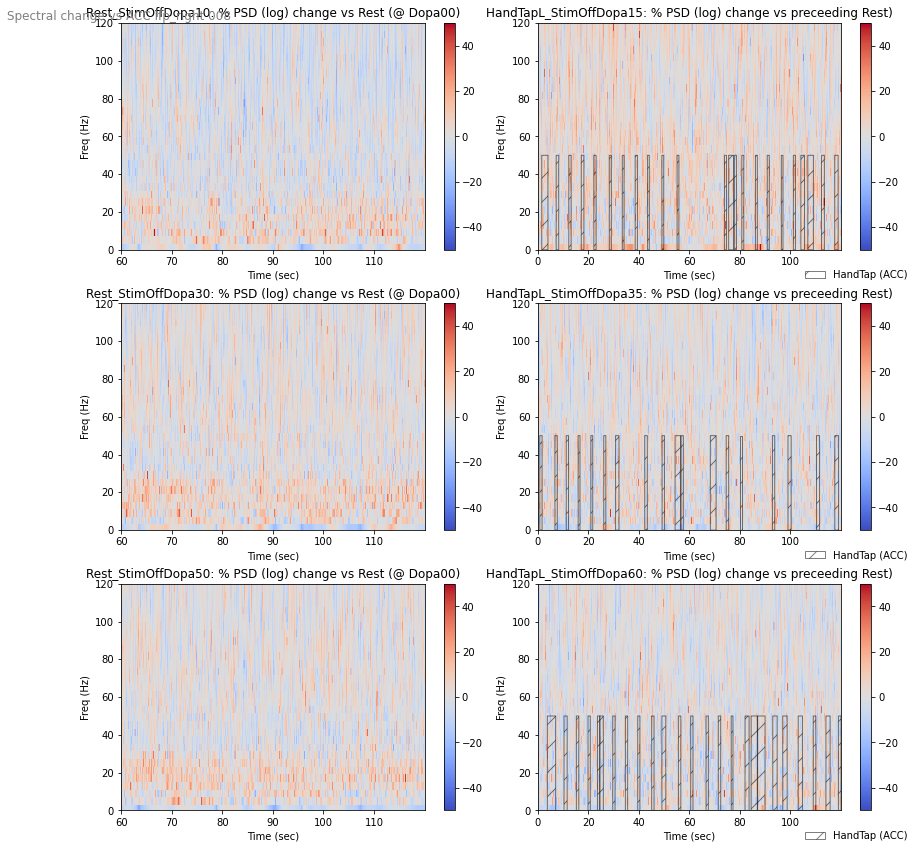

In [166]:
'''
Rest spectral changes over time, and
handtapping compared to rest before'''

base00 = 'Rest_StimOffDopa00'
runcombis = (
    ('Rest_StimOffDopa10', 'SelfpacedHandTapL_StimOffDopa15'),
    ('Rest_StimOffDopa30', 'SelfpacedHandTapL_StimOffDopa35'),
    ('Rest_StimOffDopa50', 'SelfpacedHandTapL_StimOffDopa60'),
)
datsrc = 'lfp_right' # data source
lfprow=1

fig, axes = plt.subplots(len(runcombis), 2, figsize=(12, 12))

# Plot rest states
# define base settings
base = SUB08.runs[base00]
Fs_lfp = base.lfp_right_Fs
istart = 60 * Fs_lfp
istop = 60 * Fs_lfp * 2
# define base-psd
base_arr = getattr(base, f'{datsrc}_arr')[lfprow, istart:istop]
base_t = getattr(base, f'{datsrc}_arr')[0, istart:istop]
base_t, base_f, base_psd = wavelet_log(base_t, Fs_lfp, base_arr)
for row, restrun in enumerate(runcombis):
    # define Rest of Interest
    restrun = restrun[0]
    rest_arr = getattr(
        SUB08.runs[restrun], f'{datsrc}_arr')[lfprow, istart:istop]
    rest_t = getattr(
        SUB08.runs[restrun], f'{datsrc}_arr')[0, istart:istop]
    rest_t, rest_f, rest_psd = wavelet_log(rest_t, Fs_lfp, rest_arr)
    # Correct Rest-psd for Base-psd
    change_psd = rest_psd - base_psd  # calc change to Rest base00
    change_psd = (change_psd / base_psd) * 100  # calc in perc of base00
    # Plot wavelet psd
    im = axes[row, 0].pcolormesh(
        rest_t, rest_f, change_psd, cmap='coolwarm', vmin=-50, vmax=50,
    )
    fig.colorbar(im, ax=axes[row, 0], )
    axes[row, 0].set_title(f'{restrun}: % PSD (log) change vs Rest (@ Dopa00)')
    axes[row, 0].set_ylabel('Freq (Hz)')
    axes[row, 0].set_ylim(0, 120)
    axes[row, 0].set_xlabel('Time (sec)')


istart = 0 * Fs_lfp
istop = 60 * Fs_lfp * 2
# Plot Tap Runs
for row, runset in enumerate(runcombis):
    baserun, taprun = runset
    print(baserun, taprun)
    # Base
    base_arr = getattr(
        SUB08.runs[baserun], f'{datsrc}_arr')[lfprow, istart:istop]
    base_t = getattr(
        SUB08.runs[baserun], f'{datsrc}_arr')[0, istart:istop]
    base_t, base_f, base_psd = wavelet_log(base_t, Fs_lfp, base_arr)
    # Tap
    tap_arr = getattr(
        SUB08.runs[taprun], f'{datsrc}_arr')[lfprow, istart:istop]
    tap_t = getattr(
        SUB08.runs[taprun], f'{datsrc}_arr')[0, istart:istop]
    tap_t, tap_f, tap_psd = wavelet_log(tap_t, Fs_lfp, tap_arr)
    # Correct Rest-psd for Base-psd
    change_psd = tap_psd - base_psd  # calc change to Rest base00
    change_psd = (change_psd / base_psd) * 100  # calc in perc of base00
    # Plot
    im = axes[row, 1].pcolormesh(
        tap_t, tap_f, change_psd,
        cmap='coolwarm', vmin=-50, vmax=50,
    )
    fig.colorbar(im, ax=axes[row, 1], )

    axes[row, 1].set_title(f'{taprun[9:]}: % PSD (log) change vs preceeding Rest)')
    axes[row, 1].set_ylabel('Freq (Hz)')
    axes[row, 1].set_ylim(0, 120)
    # axes[row, 1].set_xlim(istart, istop)
    axes[row, 1].set_xlabel('Time (sec)')

    if taprun in runblocks.keys():
        for movb in runblocks[taprun]:
            axes[row, 1].fill_between(
                y1=0,
                y2=50,
                x=tap_t,
                where=np.logical_and(
                    runblocks[taprun][movb][0] < tap_t,
                    tap_t < runblocks[taprun][movb][-1]
                ),
                color='none', alpha=.5, hatch='/',
                edgecolor='k',
            )
            if movb == 0: axes[row, 1].legend(
                ['HandTap (ACC)'],
                loc='upper left',
                bbox_to_anchor=(.85, -.05),
                frameon=False,
            )

fname = (f'Spectral change vs ACC {datasource} '
         f'{SUB08.runs[taprun].sub}')
plt.suptitle(
    fname,
    color='gray', x=.05, y=.02,)
plt.tight_layout(pad=.5)
# plt.savefig(os.path.join(temp_save, fname),
#     dpi=150, facecolor='w',)
plt.show()





In [167]:
SUB08.runs_incl

['Rest_StimOffDopa00',
 'SelfpacedHandTapL_StimOffDopa60',
 'Rest_StimOffDopa30',
 'SelfpacedHandTapL_StimOffDopa35',
 'Rest_StimOffDopa10',
 'Rest_StimOffDopa50',
 'SelfpacedHandTapL_StimOffDopa15']

In [174]:
for movb in runblocks['SelfpacedHandTapL_StimOffDopa15']:
    print(runblocks['SelfpacedHandTapL_StimOffDopa15'][movb][0],
        runblocks['SelfpacedHandTapL_StimOffDopa15'][movb][-1],
        len(runblocks['SelfpacedHandTapL_StimOffDopa15'][movb]) / 200)

1.64 4.085 2.45
7.345 8.345 1.005
12.33 13.265 0.94
17.27 18.31 1.045
22.23 23.145 0.92
28.35 29.165 0.82
33.49 34.2 0.715
38.59 39.48 0.895
43.48 44.175 0.7
49.15 49.875 0.73
55.155 55.88 0.73
73.895 74.7 0.81
75.545 77.485 1.945
77.81 78.635 0.83
80.76 81.53 0.775
86.145 86.9 0.76
90.815 91.62 0.81
96.39 97.04 0.655
101.145 101.97 0.83
104.105 105.555 1.455
106.855 109.075 2.225
112.275 113.415 1.145
117.495 118.855 1.365
122.68 123.97 1.295
129.175 130.305 1.135
139.755 140.91 1.16
145.645 146.785 1.145
150.775 151.91 1.14
155.585 156.97 1.39
161.67 162.65 0.985
166.83 168.0 1.175
173.54 174.62 1.085
180.475 182.515 2.045
188.16 189.915 1.76
194.245 195.14 0.9
195.58 196.345 0.77


In [276]:
importlib.reload(expl_plot)
expl_plot.electrode_spectral_check(
    sessionClass=SUB08,
    savedir=os.path.join(
        projectpath, 'figures', 'TEMP', 'spectral_tests'
    ),
    sides=['ecog', 'lfp_left'],  # add optionality for one column fig!
    fname_add='_RestMov_ECOG_welch' ,  #'_incl_Movem',
    tasks_incl=['Rest', 'Selfp'],  # has to be list (max first 5 letters)
    method='Welch',
)

'Figure saved!'

In [ ]:
ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
        sig,
        fs=Fs,
        freq_limits=[1, 120]  # [flim[0], flim[1]]
    )
    ghs_psd = np.abs(ghs_cfs)**2 / Fs
    # alt psd calc: hgs_cfs.real**2 + ghs_cfs.imag**2
    ghs_psd /= np.max(ghs_psd)  # normalisation
    axes[0].pcolormesh(time, ghs_f, ghs_psd, cmap='viridis')
    axes[0].set_title('Ghostipy Cont. Wavelet Transform')

    # scipy CWT
    w = 8  # depth/spaces?
    scp_f = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * scp_f * np.pi)
    # mor = signal.morlet2(M=100, s=4, w=2)
    scp_cfs = signal.cwt(sig, signal.morlet2, widths=widts, w=w, dtype='complex128')
    scp_psd = np.abs(scp_cfs)
    scp_psd /= np.max(scp_psd)  # normalisation
    axes[1].pcolormesh(time, scp_f, scp_psd, cmap='viridis')
    axes[1].set_title('SciPy Cont. Wavelet Transform')

    # scipy spectrogram
    npseg = 256
    fft_f, fft_t, fft_psd = signal.spectrogram(
        sig, fs=Fs, nperseg=npseg
    )  # or welch
    fft_t = time[(fft_t * len(time)).astype(int)]
    axes[2].pcolormesh(fft_t, fft_f, fft_psd)
    axes[2].set_title('SciPy Spectrogram (FFT)')

In [ ]:
g = 'lfp_left'
c = 2
chname = tempnms['00'][g][c]

data00 = tempdat['00'][g]
# data10 = tempdat['10'][g]
# data30 = tempdat['30'][g]
# data50 = tempdat['50'][g]
norm = 'std'

# for nrm in ['std', 'nrm', 'LOG']:
nrm = 'std'
for dff in ['minus', '%Change']:  # 
    plot_spectral_course(
        basedata=data00,
        dopa_data_dict=tempdat,
        dopa_names=tempnms['00'],
            dopa_keys=[ '50',],  #'10', '30',
            group=g,
            ch=c,
            norm=nrm,
            diff=dff,
        )


        ### WHY BETA INCREASE IN LOG VERSION??!!!


In [ ]:
def plot_spectral_course(
    basedata, dopa_data_dict, dopa_names, dopa_keys: list,
    group: str, ch: int, norm: str, diff: str,
):
    '''
    Plot spectral differences between session and baseline session.
    '''
    chname = dopa_names[group][ch]

    fig,axes = plt.subplots(
        len(dopa_keys), 3,
        sharey='row', sharex='col',
        figsize=(10, 6 * len(dopa_keys)))
    axes = axes.flatten()
    for row, dopaXX in enumerate(dopa_keys):
        dopadata = dopa_data_dict[dopaXX][group]

        for w in range(basedata.shape[0] // 10):
            d = np.hstack(basedata[w * 10:(w * 10) + 10, ch, :])
            f, t, ps = signal.spectrogram(
                d, fs=800, nperseg=256,
            )
            if w == 0:
                basepsd = np.empty((
                    basedata.shape[0] // 10,
                    len(f),
                    len(t),
                ))
            basepsd[w, :, :] = ps

        if nrm != 'LOG': basepsd = normalize(basepsd, norm)
        if nrm == 'LOG': basepsd = np.log(basepsd)
        basemean = np.nanmean(basepsd, axis=0)
        # Plot base (col-0)
        if nrm == 'LOG':
            im = axes[row * 3 + 0].pcolormesh(
                t, f, basemean, cmap='viridis', vmin=-35, vmax=-30,)
        elif nrm == 'std':
            im = axes[row * 3 + 0].pcolormesh(
                t, f, basemean, cmap='viridis', vmin=0, vmax=4,)
        else:
            im = axes[row * 3 + 0].pcolormesh(t, f, basemean, cmap='viridis')
        fig.colorbar(im, ax=axes[row * 3 + 0], )
        axes[row * 3 + 0].set_title('BASE')
        axes[row * 3 + 0].set_ylabel(f'Freq (Hz, {norm})')

        dopapsd = np.empty((
                    dopadata.shape[0] // 10,
                    len(f),
                    len(t),
                ))
        for w in range(dopapsd.shape[0]):
            d = np.hstack(dopadata[w * 10:(w * 10) + 10, ch, :])
            f, t, ps = signal.spectrogram(
                d, fs=800, nperseg=256)
            dopapsd[w, :, :] = ps
        if nrm != 'LOG': dopapsd = normalize(dopapsd, norm)
        if nrm == 'LOG': dopapsd = np.log(dopapsd)
        dopamean = np.nanmean(dopapsd, axis=0)
        # plot DOPA, col-1
        if nrm == 'LOG':
            im = axes[row * 3 + 0].pcolormesh(
                t, f, dopamean, cmap='viridis', vmin=-35, vmax=-30,)
        elif nrm == 'std':
            im = axes[row * 3 + 1].pcolormesh(
                t, f, dopamean, cmap='viridis', vmin=0, vmax=4,)
        else:
            im = axes[row * 3 + 1].pcolormesh(t, f, dopamean, cmap='viridis')
        fig.colorbar(im, ax=axes[row * 3 + 1], )
        axes[row * 3 + 1].set_title(f'DOPA {dopa_keys[row]}')

        # DIFF
        if diff[0] == '%':  # define plot limits
            if nrm == 'LOG':
                powlims = (-5, 5)
            else:
                powlims = (-200, 200)
        elif nrm == 'LOG':
            powlims = (-1, 1)
        else:
            if norm == 'nrm':
                powlims = (-.1, .1)
            elif norm == 'std':
                powlims = (-3, 3)
        if diff == 'minus': psdiff = dopapsd - basemean
        if diff == '%Change': psdiff = ((dopapsd / basemean) * 100) - 100
        psdiff = np.nanmean(psdiff, axis=0)
        im = axes[row * 3 + 2].pcolormesh(t, f, psdiff,
            cmap='coolwarm', vmin=powlims[0], vmax=powlims[1])
        fig.colorbar(im, ax=axes[row * 3 + 2], )
        axes[row * 3 + 2].set_title(f'DIFF ({diff})')

        # all plots
        for ax in axes:
            ax.set_ylim(0, 100)
            ax.set_xlabel('Time (sec)')

    plt.suptitle(f'{RunInfo.store_str} ({group}: {chname})',
                c='gray', alpha=.5, y=.99, x=.4)
    plt.tight_layout(w_pad=.05)
    plt.savefig(os.path.join(spec_fig,
                f'SPEC_TEST_00vs{dopa_keys}_{norm}_{diff}'),
                facecolor='white', dpi=150)
    plt.close()


In [ ]:
pd.DataFrame(psdiff).describe()

0             1           2            3            4   \
count  129.000000    129.000000  129.000000   129.000000   129.000000   
mean    11.338391    230.777068    1.730689   -36.526793    25.217338   
std     65.031270   1830.850918   46.137900   681.147310   119.234502   
min   -214.746070   -175.174992 -233.425535 -7322.934606  -251.777062   
25%     15.535429     14.562407   14.005507    15.451850    15.586630   
50%     15.890705     15.890651   15.890641    15.894880    15.890733   
75%     15.890755     15.890755   15.890755    15.895808    15.890755   
max    420.370039  17877.932533  153.251521  1937.059574  1071.750687   

                5           6           7           8            9   ...  \
count   129.000000  129.000000  129.000000  129.000000   129.000000  ...   
mean     19.648497    9.333329    6.386118    1.136534    11.150465  ...   
std     161.103864   64.829212   41.966471   72.460560   136.606070  ...   
min    -529.317798 -384.695062 -204.853201 -744.913064  -641.556306  ...   
25%      15.837505   15.725187   15.680995   13.382596    14.749264  ...   
50%      15.890734   15.890712   15.896433   15.890439    15.890519  ...   
75%      15.890755   15.890755   15.898225   15.890755    15.890755  ...   
max    1678.177767  330.768509  117.748807   88.281555  1293.917125  ...   

                 26          27          28          29          30  \
count    129.000000  129.000000  129.000000  129.000000  129.000000   
mean    -137.809805    8.493589   -1.575030    9.986192   13.849771   
std     1649.197910   61.878133   84.355342   66.570767   57.173457   
min   -18717.328824 -244.786409 -609.266911 -470.858066 -214.815553   
25%       15.484896   14.861358   15.204023   15.384578   15.667523   
50%       15.890726   15.890569   15.890723   15.809812   15.890732   
75%       15.890755   15.890755   15.890755   15.856090   15.890755   
max      126.798516  439.881128  103.218793  205.991854  349.876839   

                 31          32          33          34          35  
count    129.000000  129.000000  129.000000  129.000000  129.000000  
mean     -65.049606   10.310639   -1.052715   -5.182092   10.754419  
std      893.983519   42.550590   98.878356   80.808166   57.111369  
min   -10124.247438 -142.779837 -763.495852 -564.489765 -345.774088  
25%       15.740849   13.658483   15.030008   13.898907   15.742409  
50%       15.890733   15.800430   15.890689   15.890560   15.890723  
75%       15.890755   15.860461   15.890755   15.890755   15.890755  
max      242.894342  209.298387  418.124020  137.557715  224.012386  

[8 rows x 36 columns]

In [ ]:
spec_fig = os.path.join(projectpath, 'figures', 'TEMP', 'spectral_tests')
os.mkdir(spec_fig)

In [ ]:
importlib.reload(expl_plot)
importlib.reload(fltrs)

Fs = 800

# Read in Preprocessed Data
for n in [7, 10]:  # fileDict
    RunInfo = dataMng.RunInfo(
        sub=fileDict[n]['sub'],
        ses=fileDict[n]['ses'],
        task=fileDict[n]['task'],
        acq=fileDict[n]['acq'],
        run=fileDict[n]['run'],
        raw_path='',
        project_path=fileDict[n]['projpath'],
        preproc_sett=fileDict[n]['version'],
    )
    print(f'start: {RunInfo.acq}')

# PM: change later fig-folder-structure
    data, names = dataMng.read_preprocessed_data(RunInfo)
    fig_path_expl = (f'{projectpath}/figures/exploration/'
                    f'sub-{RunInfo.sub}/{RunInfo.store_str}'
                    f'/{RunInfo.preproc_sett}')
    temp_save = f'{projectpath}/figures/TEMP/{RunInfo.store_str}'
    if not os.path.exists(temp_save): os.mkdir(temp_save)

    n_wins = 30

    mean=True
    diff=True

    # Plot Wavelet Decomp
    max_chs = max([data[g].shape[1] for g in data])  # largest ch-number
    fig, axes = plt.subplots(
        max_chs - 1, len(data), figsize=(12, 16), sharex='row',
        sharey='col',)
    for ax, g in enumerate(data):
        if g[-4:] != 'left': print('skip', g)
        if g[-4:] != 'left': continue
        for n, ch in enumerate(names[g][2:3]):  # select LESS CHANNELS FOR TIME
            if ch == 'time':
                print('skip time row')
                continue
            elif n in [1, 4, 5, 6]:
                print(ch,'skipped bcs of time')
                continue
            print('start',ax, g, n, ch)
            if mean:
                full_wins = data[g].shape[0] // n_wins
                for wstart in np.arange(full_wins):
                    sig = np.hstack(
                        data[g][n_wins * wstart:n_wins * (wstart + 1),
                                n,
                                :,]
                    )
                    ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
                        sig,
                        fs=Fs,
                        freq_limits=[1,100],  # [flim[0], flim[1]]
                    )
                    ghs_psd = np.abs(ghs_cfs)**2 / Fs
                    ghs_psd /= np.max(ghs_psd)  # normalisation
                    if wstart == 0:  # create once 3d array to store psds
                        
                        psds = np.empty((full_wins,
                                         ghs_psd.shape[0],
                                         ghs_psd.shape[1]
                        ))
                        if RunInfo.acq[-2:] == '00':  # putted to hijack first win00 as base
                            print('defining baseline 00')
                            BASE_psd = ghs_psd.copy()
                            print(BASE_psd.shape)

                    psds[wstart, :, :] = ghs_psd  # one 2d array per 30-wins
                print('psds',psds.shape)
                if diff:
                    # if RunInfo.acq[-2:] == '00':  # DEFINE BASELINE
                    #     cfs_BASE, _, base_f, base_t, _ = gsp.cwt(
                    #         np.hstack(data[g][:, n, :])[:],
                    #         fs=Fs,
                    #         freq_limits=[1,100],
                    #     )
                    #     BASE_psd = np.abs(cfs_BASE)**2 / Fs
                    #     BASE_psd /= np.max(BASE_psd)
                        ### FIRST NORM AGAINST BASELINE, THEN AVERAGE WIN'S
                        # TODO: PLOT THE CHANGING REST FREQ'S OVER TIME,
                        # NORM AGAINST 30 SEC'S OF DOPA00
                        # THEN PLOT REST-CWT OVER TIME (PER 30 S, MEAN OVER 5 MINUTES?)
                    for w in range(psds.shape[0]):
                        psds[w, :, :] = (psds[w, :, :] / BASE_psd * 100) - 100  # extract the baseline cwt matrix
                        print('correct', ax, ch, w)
                        print(sum(sum(psds[w, :, :])))
                ghs_psd = np.nanmean(psds, axis=0)  # mean over all psd arrays
                print('psds new shape', ghs_psd.shape)
            else:
                sig = np.hstack(data[g][:n_wins, n, :])  # try out with 10 sec's
                ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
                    sig,
                    fs=Fs,
                    freq_limits=[1,100]  # [flim[0], flim[1]]
                )
                ghs_psd = np.abs(ghs_cfs)**2 / Fs
                # alt psd calc: hgs_cfs.real**2 + ghs_cfs.imag**2
                ghs_psd /= np.max(ghs_psd)  # normalisation
            
            # Plot
            colormap='viridis'
            if diff: colormap='coolwarm'
            im = axes[n - 1, ax].pcolormesh(
                ghs_t, ghs_f, ghs_psd, cmap=colormap, )  #vmin=-1, vmax=1,
            axes[n - 1, ax].set_title(ch)
            if ax == 0: axes[n - 1, ax].set_ylabel('Frequency (Hz)')
            fig.colorbar(im, ax=axes[n - 1, ax])
        axes[max_chs - 2, ax].set_xlabel('Time (sec)')
    plotname = f'{RunInfo.store_str}_({n_wins}_wins)'
    if mean: plotname = f'{RunInfo.store_str}_({n_wins}_wins_mean)'
    if diff: plotname += '_(%DIFF vs 3min-Dopa00)'
    print(f'saving {RunInfo.store_str}, name: {plotname}')
    plt.suptitle(f'Continuous Wavelet Transform (ghostipy): {plotname}',
                 size=14, x=.35, y=.99,)
    plt.tight_layout(h_pad=.05)
    
    plt.savefig(os.path.join(temp_save, f'CWT_{plotname}'),
                dpi=150, facecolor='white',)
    plt.close()


    # for nseg in [256, 512, ]:
    #     print('start ', nseg)
    #     expl_plot.meanPSDs_session_channels(
    #     data, names, norm='norm', nseg=nseg, RunInfo=RunInfo,
    #     save=temp_save, plot=False)

start: StimOffDopa00
skip ecog
start 1 lfp_left 0 LFP_L_1_2
(67, 24570)
psds (19, 67, 24570)
correct 1 LFP_L_1_2 0
correct 1 LFP_L_1_2 1
correct 1 LFP_L_1_2 2
correct 1 LFP_L_1_2 3
correct 1 LFP_L_1_2 4
correct 1 LFP_L_1_2 5
correct 1 LFP_L_1_2 6
correct 1 LFP_L_1_2 7
correct 1 LFP_L_1_2 8
correct 1 LFP_L_1_2 9
correct 1 LFP_L_1_2 10
correct 1 LFP_L_1_2 11
correct 1 LFP_L_1_2 12
correct 1 LFP_L_1_2 13
correct 1 LFP_L_1_2 14
correct 1 LFP_L_1_2 15
correct 1 LFP_L_1_2 16
correct 1 LFP_L_1_2 17
correct 1 LFP_L_1_2 18
psds new shape (67, 24570)
skip lfp_right
saving 008_EphysMedOn02_Rest_StimOffDopa00_1, name: 008_EphysMedOn02_Rest_StimOffDopa00_1_(30_wins_mean)_(%DIFF vs 3min-Dopa00)
start: StimOffDopa50
skip ecog
start 1 lfp_left 0 LFP_L_1_2
psds (8, 67, 24570)
correct 1 LFP_L_1_2 0
correct 1 LFP_L_1_2 1
correct 1 LFP_L_1_2 2
correct 1 LFP_L_1_2 3
correct 1 LFP_L_1_2 4
correct 1 LFP_L_1_2 5
correct 1 LFP_L_1_2 6
correct 1 LFP_L_1_2 7
psds new shape (67, 24570)
skip lfp_right
saving 008_E

In [ ]:
for g in data:
    print(g, 'start highpass 60')
    data[g] = fltrs.bp_filter(
        data[g],
        sfreq=800,
        l_freq=60,
        h_freq=None,)
    print(g, 'start low pass 90')
    data[g] = fltrs.bp_filter(
        data[g],
        sfreq=800,
        l_freq=None,
        h_freq=90,)

In [ ]:
# import single data file
sub = '009'
ses = 'EcogLfpMedOn02'
task = 'Rest'
acq = 'StimOff'
run = '01'
raw_path = ''
project_path = projectpath
sett_version = 'v0.4_Feb22'

In [ ]:
importlib.reload(dataMng)
runInfo = dataMng.RunInfo(
    sub, ses, task, acq, run,
    raw_path, project_path, sett_version,
)

### TODO: CHANGE FIG + DATA PATHS IN PREPROCESS FIG AND DATA
levdata, levnames = dataMng.read_preprocessed_data(runInfoLevels)
# make data class (data, names, fig_path)

In [ ]:
importlib.reload(dataMng)
importlib.reload(expl_plot)


for n in fileDict:
    RunInfo = dataMng.RunInfo(
        sub=fileDict[n]['sub'],
        ses=fileDict[n]['ses'],
        task=fileDict[n]['task'],
        acq=fileDict[n]['acq'],
        run=fileDict[n]['run'],
        raw_path='',
        project_path=fileDict[n]['projpath'],
        preproc_sett=fileDict[n]['version'],
    )
    print(f'\nSTART: {RunInfo.store_str}\n')

# PM: change later fig-folder-structure
    data, names = dataMng.read_preprocessed_data(RunInfo)
    fig_path_expl = (f'{projectpath}/figures/exploration/'
                    f'sub-{RunInfo.sub}/{RunInfo.store_str}'
                    f'/{RunInfo.preproc_sett}')
    # Plot
    for nseg in [256, 512, 800]:
        expl_plot.meanPSDs_session_channels(
        data, names, norm='norm', nseg=nseg, RunInfo=RunInfo,
        save=fig_path_expl, plot=False)


START: 009_EcogLfpMedOn02_SelfpacedHandFlipL_StimOffDopa50_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch

START: 009_EcogLfpMedOn02_Free_StimOffDopa55_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch

START: 009_EcogLfpMedOn02_Rest_StimOffDopa65_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch

START: 009_EcogLfpMedOn02_SelfpacedHandFlipR_StimOffDopa70_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
STAR

work according to contacts; visualize different contacts (and sources) over time and states; then choose how to prceed

### py_neuromodulation functionality

In [ ]:
pn_stream = nm_BidsStream.BidsStream(PATH_RUN=pathrun,
    PATH_BIDS=pathbidsraw,
    PATH_OUT=pathout)
pn_stream.settings

## Spectral Exploration

In [ ]:
dat = data['ecog']
nms = names['ecog']
sig = dat[110, 3, :]
time = dat[110, 0, :]

In [ ]:
winsum = 5
np.arange(0, dat.shape[0] // winsum * winsum, winsum)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295])

In [ ]:
def time2spectral(
    data, method: str, Fs: int=800,
):
    '''Timeit cwt via scipy and ghostipy'''
    ch = 3

    if method == 'ghostipy':
        winsum = 5
        startw = np.arange(
            0,
            data.shape[0] // winsum * winsum,
            winsum
        )
        for n, w in enumerate(startw):
            sig = np.hstack((
                data[w:w + winsum, ch, :]
            ))

        # for w in np.arange(data.shape[0]):
        #     sig = data[w, ch, :]

            ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
                sig,
                fs=Fs,
                freq_limits=[1, 120]  # [flim[0], flim[1]]
            )
            if w == 0:  # create empty array with nr new freqs
                specArr = np.zeros((  # 4-dimensional
                    data.shape[1] - 1,  # number of channels
                    data.shape[0] // winsum,  # windows
                    len(ghs_f),  # new freq's
                    ghs_cfs.shape[1],  # over time
                ))
            ghs_psd = np.abs(ghs_cfs)**2 / Fs
            specArr[ch, n, :, :] = ghs_psd
        

        

    return specArr, ghs_f

In [ ]:
spc3 = time2spectral(dat, method='ghostipy')
# one channel, 300 x 800 (5 min's) -> 8 min

In [ ]:
spc  # ch2 ecog
gf  # freqs


In [ ]:
time10 = np.hstack((dat[:10, 0, :]))
c2_10w = np.hstack((spc[2, :10, :, :]))

In [ ]:
def compareCWT(sig, time, Fs=800, flim=(4, 90)):

    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

    # ghostipy: https://github.com/kemerelab/ghostipy/blob/master/ghostipy/spectral/cwt.py
    # uses default Morse wavelet
    ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
        sig,
        fs=Fs,
        freq_limits=[1, 120]  # [flim[0], flim[1]]
    )
    ghs_psd = np.abs(ghs_cfs)**2 / Fs
    # alt psd calc: hgs_cfs.real**2 + ghs_cfs.imag**2
    ghs_psd /= np.max(ghs_psd)  # normalisation
    axes[0].pcolormesh(time, ghs_f, ghs_psd, cmap='viridis')
    axes[0].set_title('Ghostipy Cont. Wavelet Transform')

    # scipy CWT

    w = 8  # depth/spaces?
    scp_f = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * scp_f * np.pi)
    # mor = signal.morlet2(M=100, s=4, w=2)
    scp_cfs = signal.cwt(sig, signal.morlet2, widths=widts, w=w, dtype='complex128')
    scp_psd = np.abs(scp_cfs)
    scp_psd /= np.max(scp_psd)  # normalisation
    axes[1].pcolormesh(time, scp_f, scp_psd, cmap='viridis')
    axes[1].set_title('SciPy Cont. Wavelet Transform')

    # scipy spectrogram
    npseg = 256
    fft_f, fft_t, fft_psd = signal.spectrogram(
        sig, fs=Fs, nperseg=npseg
    )  # or welch
    fft_t = time[(fft_t * len(time)).astype(int)]
    axes[2].pcolormesh(fft_t, fft_f, fft_psd)
    axes[2].set_title('SciPy Spectrogram (FFT)')

    # plot makeup
    for ax in axes:
        ax.set_ylim(flim[0], flim[1])
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Time (sec)')

    plt.show()

    return ghs_psd, ghs_f, scp_psd, scp_f

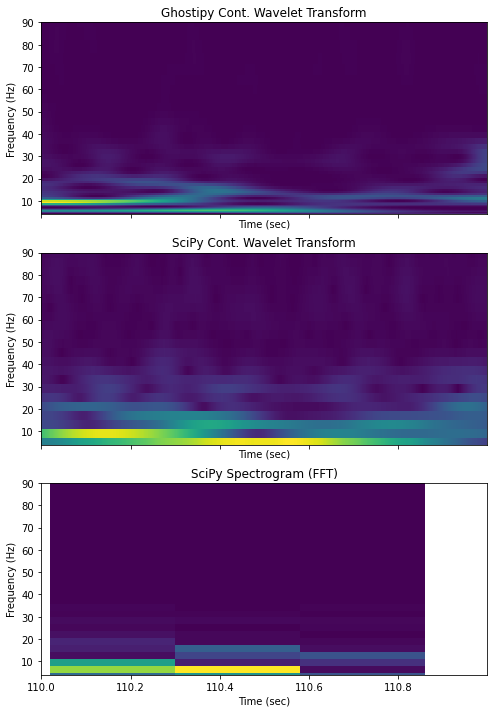

In [ ]:
sig = dat[110, 2, :]
gpsd, gf, scpsd, scf = compareCWT(sig, time)

START ecog with welch
START lfp_left with welch
START lfp_right with welch


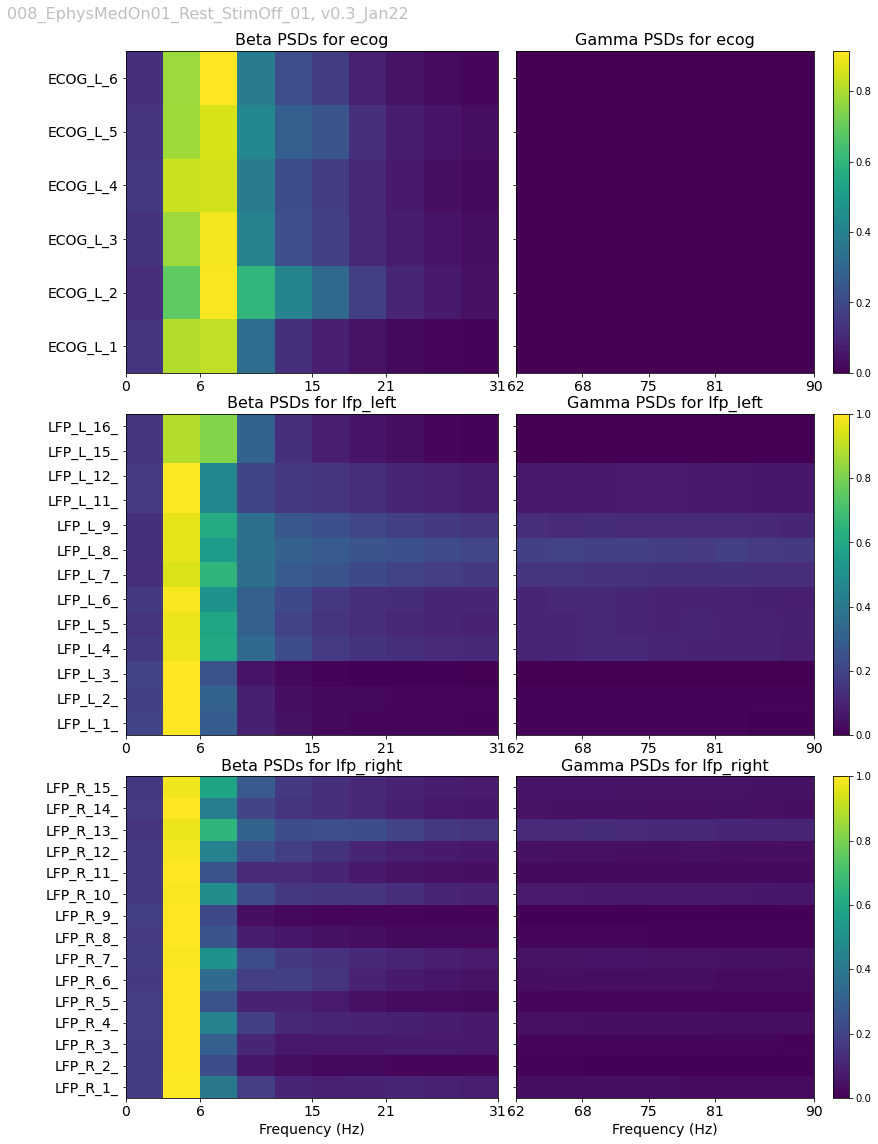

In [ ]:
# Plot PSD (beta-gamma) Channel-Overview per Session
expl_plot.meanPSDs_session_channels(
    data, names, norm='norm', nseg=256, RunInfo=runInfo,
    save=fig_path_seg)

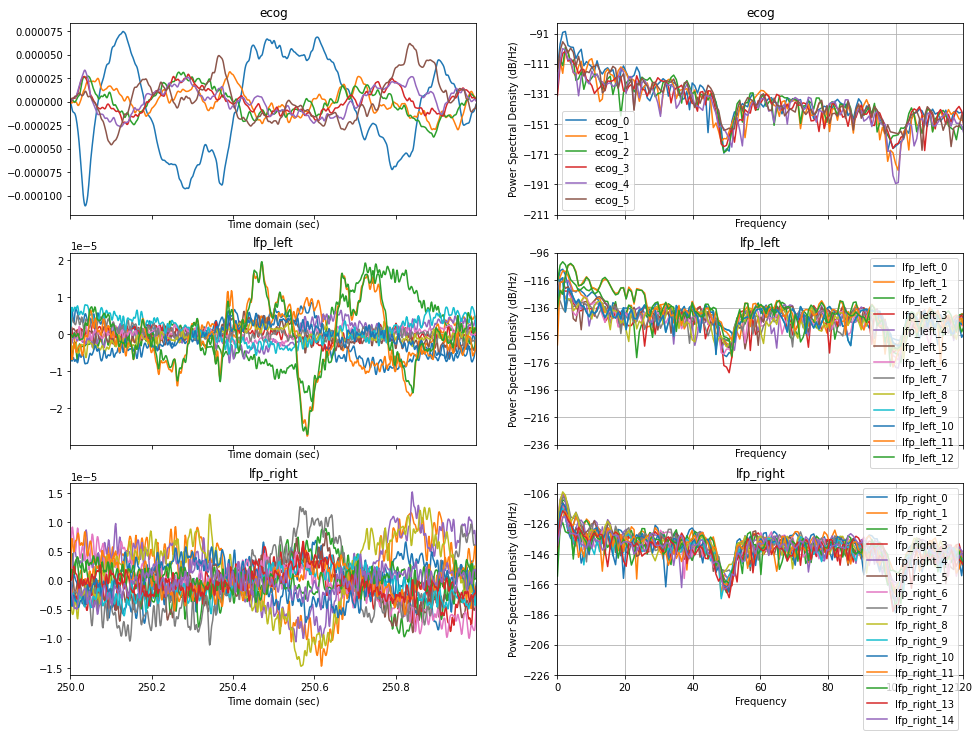

In [ ]:
fig, axes = plt.subplots(len(data), 2, sharex='col', figsize=(16,12))
w = 250
for n, g in enumerate(data):
    x = data[g][w, 0, :].T
    y = data[g][w, 1:, :].T
    # Raw
    axes[n, 0].plot(x, y)
    axes[n, 0].set_xlabel('Time domain (sec)')
    axes[n, 0].set_title(g)
    axes[n, 0].set_xlim(x[0], x[-1])
    # PSD
    for s in np.arange(y.shape[1]):
        axes[n, 1].psd(y[:, s], NFFT=1024, Fs=800, label=f'{g}_{s}')
    axes[n, 1].set_xlim(0, 120)
    axes[n, 1].set_title(g)
    axes[n, 1].legend()

plt.show()


### 2. Settings of Feature Extraction ??

In [ ]:
# APERIODIC EXPONENT
from fooof import FOOOF  # https://fooof-tools.github.io/fooof/

# cycle-by-cyle estimates
# neurodsp == 1.0.0  # install/import
# # neurodsp is a toolbox for digital signal processing for neural time series
# bycycle == 0.1.3  # install/import
# # bycycle is a toolbox for cycle-by-cycle analyses of neural oscillations

In [ ]:
## Wavelet Decomposition
power = mne.time_frequency.tfr_morlet(
    epochs, 
    freqs=freqs, 
    n_cycles=n_cycles, 
    return_itc=False, 
    picks='ecog', 
    n_jobs=-1
)

(513,)
(1026,)
(4, 513)
(513,)


#### Pro Memori: Annotations and Events

In [ ]:
# check:
events, event_id = mne.events_from_annotations(raw, event_id={"EMG_onset": 1})
epochs = mne.Epochs(raw, events=events, tmin=-5, tmax=5, baseline=None)

#### - Feature extraction and visualization

In [ ]:
freqs = np.arange(1, 100)
n_cycles = 5

#### Pro Memori: Involve py_neuromodulation-functions in Signal Analysis